In [1]:
# =========================
# 1) Canonical column rename + cleaning
# =========================

CANONICAL_MAP = {
    'import_price': 'Import_Price',
    'price_import': 'Import_Price',
    'export_price': 'Export_Price',
    'price_export': 'Export_Price',

    'P_grid_import': 'P_imp_kW',
    'grid_import': 'P_imp_kW',
    'P_grid_export': 'P_exp_kW',
    'grid_export': 'P_exp_kW',

    'P_solar': 'PV_kW',
    'P_solar_kW': 'PV_kW',
    'PV_gen_kW': 'PV_kW',
    'PV_kW': 'PV_kW',

    'P_charge': 'P_ch_kW',
    'P_discharge': 'P_dis_kW',
    'P_ch': 'P_ch_kW',
    'P_dis': 'P_dis_kW',
    'E': 'SoC_kWh',

    'Lhat_kW': 'Load_kW',
    'L_total_kW': 'Load_kW',
    'Lcrit_kW': 'Lcrit_kW',
    'Lflex_kW': 'Lflex_kW',
    'Lcurt_kW': 'Lcurt_kW',
}

def canonicalize_columns(df: pd.DataFrame, watts_to_kw=False) -> pd.DataFrame:
    """Standardize column names and optionally convert from W to kW."""
    out = df.copy()
    out.columns = out.columns.map(str)
    rename_now = {c: CANONICAL_MAP.get(c, c) for c in out.columns}
    out.rename(columns=rename_now, inplace=True)

    if watts_to_kw:
        scale = (1/1000.0) if watts_to_kw is True else float(watts_to_kw)
        power_cols = [c for c in out.columns if c.endswith('_kW') or c in ['PV_kW','P_imp_kW','P_exp_kW','P_ch_kW','P_dis_kW','Load_kW']]
        out[power_cols] = out[power_cols].astype(float) * scale
    return out

def build_prices(index: pd.DatetimeIndex, off=0.12, sh=0.18, pk=0.30, export_credit=0.06):
    """Create simple TOU import prices and a flat export credit."""
    def label(h):
        if h in [0,1,2,3,4,5,22,23]: return 'Offpeak'
        if h in [6,7,8,9,13,14,15,16,20,21]: return 'Shoulder'
        return 'Peak'
    tou = pd.Series([label(h) for h in index.hour], index=index, name='TOU')
    imp = tou.map({'Offpeak': off, 'Shoulder': sh, 'Peak': pk}).astype(float)
    exp = pd.Series(export_credit, index=index, name='Export_Price').astype(float)
    return tou, imp, exp

def sum_if_exists(df: pd.DataFrame, cols):
    cols = [c for c in cols if c in df.columns]
    return df[cols].sum(axis=1, min_count=1).fillna(0.0) if cols else pd.Series(0.0, index=df.index)

NameError: name 'pd' is not defined

In [ ]:
# =========================
# 2) Sector DV builders (canonical outputs)
# =========================

RES_PV_COLS  = [f'DE_KN_residential{i}_pv' for i in [1,3,4,6]]
RES_IMP_COLS = [f'DE_KN_residential{i}_grid_import' for i in range(1,7)]
RES_EXP_COLS = [f'DE_KN_residential{i}_grid_export' for i in [3,4,6]]

IND_PV_COLS  = ['DE_KN_industrial1_pv_1','DE_KN_industrial1_pv_2','DE_KN_industrial2_pv','DE_KN_industrial3_pv_facade','DE_KN_industrial3_pv_roof']
IND_IMP_COLS = ['DE_KN_industrial1_grid_import','DE_KN_industrial2_grid_import','DE_KN_industrial3_grid_import']

def build_sector_timeseries(df: pd.DataFrame, sector: str) -> pd.DataFrame:
    """Return canonical DV with: PV_kW, P_imp_kW, P_exp_kW, Load_kW, prices."""
    idx = df.index
    tou, pi_imp, pi_exp = build_prices(idx)
    dv = pd.DataFrame(index=idx)
    dv['TOU'] = tou
    dv['Import_Price'] = pi_imp
    dv['Export_Price'] = pi_exp

    if sector == 'residential':
        dv['PV_kW']    = sum_if_exists(df, RES_PV_COLS).astype(float)
        dv['P_imp_kW'] = sum_if_exists(df, RES_IMP_COLS).astype(float)
        dv['P_exp_kW'] = sum_if_exists(df, RES_EXP_COLS).astype(float)
    elif sector == 'industrial':
        dv['PV_kW']    = sum_if_exists(df, IND_PV_COLS).astype(float)
        dv['P_imp_kW'] = sum_if_exists(df, IND_IMP_COLS).astype(float)
        dv['P_exp_kW'] = 0.0
    else:
        raise ValueError('sector must be "residential" or "industrial"')

    dv['Load_kW'] = (dv['PV_kW'] + dv['P_imp_kW'] - dv['P_exp_kW']).clip(lower=0.0)
    for c in ['P_ch_kW','P_dis_kW','SoC_kWh']:
        dv[c] = 0.0
    return dv

def ensure_load_classes(dv: pd.DataFrame, split=(0.50, 0.30, 0.20)) -> pd.DataFrame:
    """Split total load into critical/flexible/curtailable shares."""
    out = dv.copy()
    L = out['Load_kW'].clip(lower=0.0).fillna(0.0)
    a, b, c = split
    out['Lcrit_kW'] = a * L
    out['Lflex_kW'] = b * L
    out['Lcurt_kW'] = c * L
    return out

def slice_year(df: pd.DataFrame, year=2017):
    start, end = f'{year}-01-01', f'{year}-12-31 23:59:59'
    return df.loc[start:end]

In [ ]:
dv_res = build_sector_timeseries(df, "residential")
dv_ind = build_sector_timeseries(df, "industrial")

In [ ]:
# =========================
# 4) Cost breakdown and comparison (before vs after)
# =========================

def baseline_to_report_frame(dv: pd.DataFrame) -> pd.DataFrame:
    rep = pd.DataFrame(index=dv.index)
    for c in ['P_imp_kW','P_exp_kW','PV_kW','P_ch_kW','P_dis_kW','Import_Price','Export_Price','Lcrit_kW','Lflex_kW','Lcurt_kW']:
        rep[c] = dv.get(c, 0.0)
    return rep

def solution_to_report_frame(sol: pd.DataFrame) -> pd.DataFrame:
    rep = pd.DataFrame(index=sol.index)
    for c in ['P_imp_kW','P_exp_kW','PV_kW','P_ch_kW','P_dis_kW','Import_Price','Export_Price','Lcrit_kW','Lflex_kW','Lcurt_kW']:
        rep[c] = sol.get(c, 0.0)
    return rep

def pv_self_metrics(rep: pd.DataFrame) -> dict:
    PV  = rep['PV_kW'].clip(lower=0.0)
    EXP = rep['P_exp_kW'].clip(lower=0.0)
    pv_gen  = float(PV.sum())
    pv_used = float((PV - EXP).clip(lower=0.0).sum())
    scr = 100.0 * pv_used / pv_gen if pv_gen > 0 else 0.0
    return dict(PV_gen_kWh=pv_gen, PV_used_kWh=pv_used, SelfConsumption_pct=scr)

def resource_cost_breakdown_full(
    dv_mod: pd.DataFrame,
    *, sector: str, BATTERY: dict,
    crf: float = 0.10,
    pv_capex_per_kW: float = 1200.0,
    pv_om_frac: float = 0.015,
    batt_capex_per_kWh: float = 350.0,
    batt_capex_power_per_kW: float = 150.0,
    batt_deg_cost_per_kWh: float = 0.08,
    demand_charge_rate_per_kW_month: float | None = None,
    forbid_batt_export: bool = True
) -> pd.DataFrame:
    s = dv_mod
    price_buy  = s['Import_Price'].astype(float)
    price_sell = s['Export_Price'].astype(float)

    P_imp   = s.get('P_imp_kW', pd.Series(0.0, index=s.index)).fillna(0.0).astype(float)
    P_exp   = s.get('P_exp_kW', pd.Series(0.0, index=s.index)).fillna(0.0).astype(float)
    P_solar = s.get('PV_kW',    pd.Series(0.0, index=s.index)).fillna(0.0).astype(float)
    P_ch    = s.get('P_ch_kW',  pd.Series(0.0, index=s.index)).fillna(0.0).astype(float)
    P_dis   = s.get('P_dis_kW', pd.Series(0.0, index=s.index)).fillna(0.0).astype(float)

    Lcrit = s.get('Lcrit_kW', pd.Series(0.0, index=s.index)).astype(float)
    Lflex = s.get('Lflex_kW', pd.Series(0.0, index=s.index)).astype(float)
    Lcurt = s.get('Lcurt_kW', pd.Series(0.0, index=s.index)).astype(float)
    L     = (Lcrit + Lflex + Lcurt).astype(float)

    # PV routing proxies
    D = L - P_solar
    PV_to_load   = np.minimum(P_solar, L)
    PV_to_batt   = np.where(D < 0, np.minimum(P_ch, -D), 0.0)
    Grid_to_batt = np.maximum(P_ch - PV_to_batt, 0.0)
    PV_surplus_after_batt = np.maximum(-D - PV_to_batt, 0.0)
    PV_to_export = np.minimum(P_exp, PV_surplus_after_batt) if forbid_batt_export else np.minimum(P_exp, P_solar)

    # Grid energy cost
    grid_import_cost = float((price_buy * P_imp).sum())
    export_credit    = float((price_sell * P_exp).sum())
    grid_energy_cost = grid_import_cost - export_credit

    # Demand charge (optional)
    demand_charge_cost = 0.0
    if demand_charge_rate_per_kW_month is not None:
        monthly_peak = P_imp.resample('M').max(min_count=1).fillna(0.0)
        demand_charge_cost = float((monthly_peak * demand_charge_rate_per_kW_month).sum())

    # PV value and costs
    S_pv_kW = float(P_solar.max())
    pv_self_value  = float((price_buy  * PV_to_load).sum())
    pv_export_rev  = float((price_sell * PV_to_export).sum())
    pv_capex_annual = float(crf * pv_capex_per_kW * S_pv_kW)
    pv_om_annual    = float(pv_om_frac * pv_capex_per_kW * S_pv_kW)
    pv_net_impact   = pv_self_value + pv_export_rev - (pv_capex_annual + pv_om_annual)

    # Battery costs
    bp = BATTERY[sector]
    Emax_kWh   = float(bp['Emax_kWh'])
    Pch_max_kW = float(bp['Pmax_ch_kW'])
    Pdis_max_kW= float(bp['Pmax_dis_kW'])

    batt_grid_charge_cost = float((price_buy * Grid_to_batt).sum())
    batt_deg_cost         = float(batt_deg_cost_per_kWh * P_dis.sum())
    batt_capex_annual     = float(crf * (batt_capex_per_kWh * Emax_kWh
                                         + batt_capex_power_per_kW * (Pch_max_kW + Pdis_max_kW)))
    batt_net_impact       = -(batt_grid_charge_cost + batt_deg_cost + batt_capex_annual)

    # Load-type allocation (import cost only)
    with np.errstate(divide='ignore', invalid='ignore'):
        w_crit = (Lcrit / L).replace([np.inf, -np.inf], 0.0).fillna(0.0)
        w_flex = (Lflex / L).replace([np.inf, -np.inf], 0.0).fillna(0.0)
        w_curt = (Lcurt / L).replace([np.inf, -np.inf], 0.0).fillna(0.0)
    hourly_import_cost = price_buy * P_imp
    load_import_cost_crit = float((hourly_import_cost * w_crit).sum())
    load_import_cost_flex = float((hourly_import_cost * w_flex).sum())
    load_import_cost_curt = float((hourly_import_cost * w_curt).sum())

    # Assemble
    rows = [
        ('Grid_Import_Cost',            grid_import_cost),
        ('Export_Credit',               export_credit),
        ('Grid_Energy_Cost',            grid_energy_cost),
        ('Grid_Demand_Charge',          demand_charge_cost),
        ('Grid_Total',                  grid_energy_cost + demand_charge_cost),

        ('PV_SelfConsumption_Value',    pv_self_value),
        ('PV_Export_Revenue',           pv_export_rev),
        ('PV_CapEx_Annual',             pv_capex_annual),
        ('PV_OandM_Annual',             pv_om_annual),
        ('PV_Net_Impact',               pv_net_impact),

        ('BESS_GridCharge_Cost',        batt_grid_charge_cost),
        ('BESS_Degradation_Cost',       batt_deg_cost),
        ('BESS_CapEx_Annual',           batt_capex_annual),
        ('BESS_Net_Impact',             batt_net_impact),

        ('LoadImportCost_Critical',     load_import_cost_crit),
        ('LoadImportCost_Flexible',     load_import_cost_flex),
        ('LoadImportCost_Curtailable',  load_import_cost_curt),

        ('Assumed_S_pv_kW',             float(S_pv_kW)),
        ('Assumed_Emax_kWh',            float(Emax_kWh)),
        ('Assumed_Pch_max_kW',          float(Pch_max_kW)),
        ('Assumed_Pdis_max_kW',         float(Pdis_max_kW)),
    ]
    out = pd.DataFrame(rows, columns=['Metric','Value']).set_index('Metric')

    # Cross-checks
    out.loc['Check_ImportAlloc_Sum', 'Value'] = load_import_cost_crit + load_import_cost_flex + load_import_cost_curt
    out.loc['Check_ImportAlloc_Equals_GridImportCost', 'Value'] = float(abs(out.loc['Check_ImportAlloc_Sum','Value'] - grid_import_cost) < 1e-6)
    return out


In [ ]:
# Example after a solve (per season/scenario/sector):
res_cost_breakdown = resource_cost_breakdown_full(
    dv_mod=dv_res,
    sector="residential", 
    BATTERY=BATTERY,
    crf=0.10,
    demand_charge_rate_per_kW_month=None,
    pv_capex_per_kW=1200.0,
    pv_om_frac=0.015,
    batt_capex_per_kWh=500.0,
    batt_capex_power_per_kW=300.0,
    batt_deg_cost_per_kWh=0.08
)

print(res_cost_breakdown)

                                                Value
Metric                                               
Grid_Import_Cost                         8.919389e+07
Export_Credit                            1.927663e+07
Grid_Energy_Cost                         6.991726e+07
Grid_Demand_Charge                       0.000000e+00
Grid_Total                               6.991726e+07
PV_SelfConsumption_Value                 0.000000e+00
PV_Export_Revenue                        1.927663e+07
PV_CapEx_Annual                          6.387315e+06
PV_OandM_Annual                          9.580972e+05
PV_Net_Impact                            1.193121e+07
BESS_GridCharge_Cost                     0.000000e+00
BESS_Degradation_Cost                    0.000000e+00
BESS_CapEx_Annual                        9.750000e+02
BESS_Net_Impact                         -9.750000e+02
LoadImportCost_Critical                  0.000000e+00
LoadImportCost_Flexible                  0.000000e+00
LoadImportCost_Curtailable  

In [ ]:
industrial_cost_breakdown = resource_cost_breakdown_full(
    dv_mod=dv_ind,
    sector="industrial", 
    BATTERY=BATTERY,
    demand_charge_rate_per_kW_month=18.0,
    pv_capex_per_kW=1200.0,
    pv_om_frac=0.015,
    batt_capex_power_per_kW=250.0,
    batt_deg_cost_per_kWh=0.08
)

print(industrial_cost_breakdown)

                                                Value
Metric                                               
Grid_Import_Cost                         1.713702e+09
Export_Credit                            0.000000e+00
Grid_Energy_Cost                         1.713702e+09
Grid_Demand_Charge                       2.550521e+08
Grid_Total                               1.968754e+09
PV_SelfConsumption_Value                 0.000000e+00
PV_Export_Revenue                        0.000000e+00
PV_CapEx_Annual                          6.446962e+06
PV_OandM_Annual                          9.670444e+05
PV_Net_Impact                           -7.414007e+06
BESS_GridCharge_Cost                     0.000000e+00
BESS_Degradation_Cost                    0.000000e+00
BESS_CapEx_Annual                        2.400000e+04
BESS_Net_Impact                         -2.400000e+04
LoadImportCost_Critical                  0.000000e+00
LoadImportCost_Flexible                  0.000000e+00
LoadImportCost_Curtailable  

In [ ]:
# --- TOU helpers 
TOU_PEAK_HOURS     = {10,11,12,17,18,19}
TOU_SHOULDER_HOURS = {6,7,8,9,13,14,15,16,20,21}
TOU_OFFPEAK_HOURS  = {0,1,2,3,4,5,22,23}

def tou_period(hour: int) -> str:
    if hour in TOU_OFFPEAK_HOURS:  return "offpeak"
    if hour in TOU_SHOULDER_HOURS: return "shoulder"
    return "peak"

def build_tou_masks(index):
    """Return (peak_mask, shoulder_mask, offpeak_mask) as 0/1 Series aligned to index."""
    hrs = index.hour
    return (
        (hrs.isin(list(TOU_PEAK_HOURS))).astype(int),
        (hrs.isin(list(TOU_SHOULDER_HOURS))).astype(int),
        (hrs.isin(list(TOU_OFFPEAK_HOURS))).astype(int),
    )


In [ ]:
import pulp as pl
import pandas as pd

def build_dsm_model_DR(
    dv: pd.DataFrame,
    battery: dict,
    penalties: dict,
    *,
    # TOU-based flexible shifting caps: Sflex[t] ≤ α_tou * Lflex[t]
    flex_cap = dict(peak=0.25, shoulder=1.5, offpeak=3.0),
    # Curtailable reduction limits: Ucurt[t] ≤ r_tou * Lcurt[t]
    curt_limit = dict(peak=0.30, shoulder=0.15, offpeak=0.0),
    # Demand charge (optional): $/kW-month; set None to skip
    demand_charge_rate_per_kw_month: float | None = None,
    horizon_weeks: float = 52.0,   # scale monthly rate to your horizon length
    # Optional hard cap on grid import (service limit)
    grid_cap_kW: float | None = None,
    sector: str = "residential"
):
    idx = dv.index
    T = range(len(idx))

    # ---- Parameters from dv ----
    c_buy  = dv["Import_Price"].to_dict()
    c_sell = dv["Export_Price"].to_dict()
    Lcrit  = dv["Lcrit_kW"].to_dict()
    Lflex  = dv["Lflex_kW"].to_dict()
    Lcurt  = dv["Lcurt_kW"].to_dict()
    PV     = dv["PV_kW"].to_dict()

    # Battery params
    Emax     = float(battery["Emax_kWh"]);  E0 = float(battery["E0_kWh"])
    Pmax_ch  = float(battery["Pmax_ch_kW"]); Pmax_dis = float(battery["Pmax_dis_kW"])
    eta_ch   = float(battery["eta_ch"]);     eta_dis  = float(battery["eta_dis"])

    # Penalties
    a_crit = float(penalties.get("crit_unserved", 1000.0))
    a_curt = float(penalties.get("curt_unserved", 100.0))

    # Demand charge scaling
    if demand_charge_rate_per_kw_month is not None:
        weeks_per_month = 4.345
        a_peak = float(demand_charge_rate_per_kw_month) * (horizon_weeks / weeks_per_month)
    else:
        a_peak = 0.0

    # ---- Model ----
    m = pl.LpProblem(f"DSM_DR_{sector}", pl.LpMinimize)

    # Decision variables
    P_imp = pl.LpVariable.dicts("P_imp", T, lowBound=0)
    P_exp = pl.LpVariable.dicts("P_exp", T, lowBound=0)
    P_ch  = pl.LpVariable.dicts("P_ch",  T, lowBound=0, upBound=Pmax_ch)
    P_dis = pl.LpVariable.dicts("P_dis", T, lowBound=0, upBound=Pmax_dis)
    E     = pl.LpVariable.dicts("E",     T, lowBound=0, upBound=Emax)

    Sflex = pl.LpVariable.dicts("Sflex", T, lowBound=0)  # served flexible load
    Scurt = pl.LpVariable.dicts("Scurt", T, lowBound=0)  # served curtailable
    Ucrit = pl.LpVariable.dicts("Ucrit", T, lowBound=0)
    Ucurt = pl.LpVariable.dicts("Ucurt", T, lowBound=0)

    Zpk = pl.LpVariable("PeakImport", lowBound=0)        # peak demand tracker (kW)

    # Objective: energy bill + reliability + demand charge
    m += (
        pl.lpSum(c_buy[idx[t]]*P_imp[t] - c_sell[idx[t]]*P_exp[t]
                 + a_crit*Ucrit[t] + a_curt*Ucurt[t] for t in T)
        + a_peak * Zpk
    ), "Total_Cost"

    # (1) Flexible energy conservation (Δt=1h)
    m += pl.lpSum(Sflex[t] for t in T) == float(dv["Lflex_kW"].sum()), "flex_energy_quota"

    # (2) TOU-based caps for Sflex and Ucurt
    for t in T:
        ts = idx[t]
        hour = ts.hour
        period = "offpeak" if hour in TOU_OFFPEAK_HOURS else "shoulder" if hour in TOU_SHOULDER_HOURS else "peak"

        # Sflex cap
        m += Sflex[t] <= float(flex_cap[period]) * Lflex[ts], f"sflex_cap_{t}"

        # Curtailable served+unserved and unserved limit by TOU
        m += Scurt[t] + Ucurt[t] == Lcurt[ts], f"curt_balance_{t}"
        m += Ucurt[t] <= float(curt_limit[period]) * Lcurt[ts], f"curt_limit_{t}"

    # (3) Power balance
    for t in T:
        ts = idx[t]
        m += PV[ts] + P_dis[t] + P_imp[t] == (Lcrit[ts] - Ucrit[t]) + Sflex[t] + Scurt[t] + P_ch[t] + P_exp[t], f"bal_{t}"

    # (4) Battery SoC (Δt=1h) + cyclic end
    for t in T:
        if t == 0:
            m += E[t] == E0 + eta_ch*P_ch[t] - (1/eta_dis)*P_dis[t], f"soc_{t}"
        else:
            m += E[t] == E[t-1] + eta_ch*P_ch[t] - (1/eta_dis)*P_dis[t], f"soc_{t}"
    m += E[len(idx)-1] == E0, "soc_cycle"

    # (5) Peak tracker and optional hard cap
    for t in T:
        m += P_imp[t] <= Zpk, f"peak_track_{t}"
        if grid_cap_kW is not None:
            m += P_imp[t] <= float(grid_cap_kW), f"grid_cap_{t}"

    # Solve
    m.solve(pl.PULP_CBC_CMD(msg=False))

    # Collect solution
    sol = pd.DataFrame(index=idx)
    sol["P_imp_kW"] = [pl.value(P_imp[t]) for t in T]
    sol["P_exp_kW"] = [pl.value(P_exp[t]) for t in T]
    sol["P_ch_kW"]  = [pl.value(P_ch[t])  for t in T]
    sol["P_dis_kW"] = [pl.value(P_dis[t]) for t in T]
    sol["SoC_kWh"]  = [pl.value(E[t])     for t in T]
    sol["Sflex_kW"] = [pl.value(Sflex[t]) for t in T]
    sol["Scurt_kW"] = [pl.value(Scurt[t]) for t in T]
    sol["Ucrit_kW"] = [pl.value(Ucrit[t]) for t in T]
    sol["Ucurt_kW"] = [pl.value(Ucurt[t]) for t in T]
    sol["PeakImport_kW"] = float(pl.value(Zpk))

    # pass-through
    for c in ["PV_kW","Import_Price","Export_Price","Lcrit_kW","Lflex_kW","Lcurt_kW"]:
        sol[c] = dv[c].values

    # Hourly bill
    sol["Energy_Cost"] = sol["P_imp_kW"]*sol["Import_Price"] - sol["P_exp_kW"]*sol["Export_Price"]
    return m, sol, pl.LpStatus[m.status], float(pl.value(m.objective))


In [ ]:
# =========================
# Baseline vs Optimized cost (no self-consumption metric)
# =========================
def compare_costs_only(dv: pd.DataFrame, sol: pd.DataFrame) -> dict:
    Pimp0 = dv.get("P_imp_kW", pd.Series(0.0, index=dv.index))
    Pexp0 = dv.get("P_exp_kW", pd.Series(0.0, index=dv.index))
    base_cost = float((dv["Import_Price"]*Pimp0 - dv["Export_Price"]*Pexp0).sum())
    opt_cost  = float((sol["Import_Price"]*sol["P_imp_kW"] - sol["Export_Price"]*sol["P_exp_kW"]).sum())
    savings   = base_cost - opt_cost
    pct = (savings/base_cost*100.0) if base_cost else 0.0
    return dict(Base_Grid_Total=base_cost, Opt_Grid_Total=opt_cost, Savings=savings, Savings_pct=pct)

# Cost-only comparison 
base_vs_opt = compare_costs_only(dvY, sol)
print(base_vs_opt)

{'Base_Grid_Total': 1035312133.90362, 'Opt_Grid_Total': 1819010.3656410002, 'Savings': 1033493123.537979, 'Savings_pct': 99.82430319262438}


In [ ]:
# Example: 2017, residential (change sector='industrial' to switch)

dv_residential = prepare_sector_year(df_raw, sector='residential', year=2017)

m, sol, status, obj = build_dsm_model_DR(
    dv_residential, BATTERY['residential'], PENALTIES,
    flex_cap   = dict(peak=0.25, shoulder=1.5, offpeak=3.0),   # shifting limits
    curt_limit = dict(peak=0.30, shoulder=0.15, offpeak=0.0),  # curtailable limits
    demand_charge_rate_per_kw_month=None,  # or e.g. 15.0 to monetize peak
    grid_cap_kW=None,                      # or a service limit in kW
    sector='residential'
)

print({'status': status, 
       'objective': round(obj,2)})


{'status': 'Optimal', 'objective': 1819010.37}


In [ ]:
results = {}  # (sector, year) -> dict of outputs

for sec in ["residential", "industrial"]:
    dvY = prepare_sector_year(df_raw, sector=sec, year=2017)

    m, sol, status, obj = build_dsm_model_DR(
        dvY, BATTERY[sec], PENALTIES,
        flex_cap=dict(peak=0.25, shoulder=1.5, offpeak=3.0),
        curt_limit=dict(peak=0.30, shoulder=0.15, offpeak=0.0),
        demand_charge_rate_per_kw_month=None,
        grid_cap_kW=None,
        sector=sec
    )

    # store a deep copy so later edits won't affect this snapshot
    results[(sec, 2017)] = {
        "model": m,
        "sol": sol.copy(deep=True),
        "status": status,
        "objective": obj
    }

sol_res_2017 = results[("residential", 2017)]["sol"]
sol_ind_2017 = results[("industrial", 2017)]["sol"]


In [ ]:
sol_ind_2017

,P_imp_kW,P_exp_kW,P_ch_kW,P_dis_kW,SoC_kWh,Sflex_kW,Scurt_kW,Ucrit_kW,Ucurt_kW,PeakImport_kW,PV_kW,Import_Price,Export_Price,Lcrit_kW,Lflex_kW,Lcurt_kW,Energy_Cost
2017-01-01 00:00:00+00:00,1.462396e+06,0.0,0.000000,0.0,200.0,850640.29,189031.18,0.0,0.0,2110874.5,49853.009,0.12,0.06,472577.9415,283546.7649,189031.1766,175487.568000
2017-01-01 01:00:00+00:00,1.462464e+06,0.0,0.000000,0.0,200.0,850678.12,189039.58,0.0,0.0,2110874.5,49853.009,0.12,0.06,472598.9550,283559.3730,189039.5820,175495.632000
2017-01-01 02:00:00+00:00,1.462532e+06,0.0,0.000000,0.0,200.0,850716.84,189048.19,0.0,0.0,2110874.5,49853.009,0.12,0.06,472620.4690,283572.2814,189048.1876,175503.900000
2017-01-01 03:00:00+00:00,1.462600e+06,0.0,0.000000,0.0,200.0,850754.82,189056.63,0.0,0.0,2110874.5,49853.009,0.12,0.06,472641.5670,283584.9402,189056.6268,175512.000000
2017-01-01 04:00:00+00:00,1.462676e+06,0.0,10.526316,0.0,210.0,850791.50,189064.78,0.0,0.0,2110874.5,49853.009,0.12,0.06,472661.9460,283597.1676,189064.7784,175521.084000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 19:00:00+00:00,0.000000e+00,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,2110874.5,0.000,0.30,0.06,0.0000,0.0000,0.0000,0.000000
2017-12-31 20:00:00+00:00,0.000000e+00,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,2110874.5,0.000,0.18,0.06,0.0000,0.0000,0.0000,0.000000
2017-12-31 21:00:00+00:00,0.000000e+00,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,2110874.5,0.000,0.18,0.06,0.0000,0.0000,0.0000,0.000000
2017-12-31 22:00:00+00:00,2.000000e+02,0.0,200.000000,0.0,190.0,0.00,0.00,0.0,0.0,2110874.5,0.000,0.12,0.06,0.0000,0.0000,0.0000,24.000000


In [ ]:
sol_labeled = sol.copy(deep=True)
sol_labeled["sector"] = sec
sol_labeled["year"]   = 2017
sol_labeled = sol_labeled.set_index(["sector","year"], append=True).reorder_levels(["sector","year", sol_labeled.index.names[0]])


In [ ]:

sol_labeled

P_imp_kW  P_exp_kW     P_ch_kW  \
sector     year                                                                 
industrial 2017 2017-01-01 00:00:00+00:00  1.462396e+06       0.0    0.000000   
                2017-01-01 01:00:00+00:00  1.462464e+06       0.0    0.000000   
                2017-01-01 02:00:00+00:00  1.462532e+06       0.0    0.000000   
                2017-01-01 03:00:00+00:00  1.462600e+06       0.0    0.000000   
                2017-01-01 04:00:00+00:00  1.462676e+06       0.0   10.526316   
...                                                 ...       ...         ...   
                2017-12-31 19:00:00+00:00  0.000000e+00       0.0    0.000000   
                2017-12-31 20:00:00+00:00  0.000000e+00       0.0    0.000000   
                2017-12-31 21:00:00+00:00  0.000000e+00       0.0    0.000000   
                2017-12-31 22:00:00+00:00  2.000000e+02       0.0  200.000000   
                2017-12-31 23:00:00+00:00  1.052632e+01       0.0   10.526316   

                                           P_dis_kW  SoC_kWh   Sflex_kW  \
sector     year                                                           
industrial 2017 2017-01-01 00:00:00+00:00       0.0    200.0  850640.29   
                2017-01-01 01:00:00+00:00       0.0    200.0  850678.12   
                2017-01-01 02:00:00+00:00       0.0    200.0  850716.84   
                2017-01-01 03:00:00+00:00       0.0    200.0  850754.82   
                2017-01-01 04:00:00+00:00       0.0    210.0  850791.50   
...                                             ...      ...        ...   
                2017-12-31 19:00:00+00:00       0.0      0.0       0.00   
                2017-12-31 20:00:00+00:00       0.0      0.0       0.00   
                2017-12-31 21:00:00+00:00       0.0      0.0       0.00   
                2017-12-31 22:00:00+00:00       0.0    190.0       0.00   
                2017-12-31 23:00:00+00:00       0.0    200.0       0.00   

                                            Scurt_kW  Ucrit_kW  Ucurt_kW  \
sector     year                                                            
industrial 2017 2017-01-01 00:00:00+00:00  189031.18       0.0       0.0   
                2017-01-01 01:00:00+00:00  189039.58       0.0       0.0   
                2017-01-01 02:00:00+00:00  189048.19       0.0       0.0   
                2017-01-01 03:00:00+00:00  189056.63       0.0       0.0   
                2017-01-01 04:00:00+00:00  189064.78       0.0       0.0   
...                                              ...       ...       ...   
                2017-12-31 19:00:00+00:00       0.00       0.0       0.0   
                2017-12-31 20:00:00+00:00       0.00       0.0       0.0   
                2017-12-31 21:00:00+00:00       0.00       0.0       0.0   
                2017-12-31 22:00:00+00:00       0.00       0.0       0.0   
                2017-12-31 23:00:00+00:00       0.00       0.0       0.0   

                                           PeakImport_kW      PV_kW  \
sector     year                                                       
industrial 2017 2017-01-01 00:00:00+00:00      2110874.5  49853.009   
                2017-01-01 01:00:00+00:00      2110874.5  49853.009   
                2017-01-01 02:00:00+00:00      2110874.5  49853.009   
                2017-01-01 03:00:00+00:00      2110874.5  49853.009   
                2017-01-01 04:00:00+00:00      2110874.5  49853.009   
...                                                  ...        ...   
                2017-12-31 19:00:00+00:00      2110874.5      0.000   
                2017-12-31 20:00:00+00:00      2110874.5      0.000   
                2017-12-31 21:00:00+00:00      2110874.5      0.000   
                2017-12-31 22:00:00+00:00      2110874.5      0.000   
                2017-12-31 23:00:00+00:00      2110874.5      0.000   

                                           Import_Price  Export_Price  \
sector     year                

In [ ]:
# =========================
# Baseline vs Optimized cost (no self-consumption metric)
# =========================
def compare_costs_only(dv: pd.DataFrame, sol: pd.DataFrame) -> dict:
    Pimp0 = dv.get("P_imp_kW", pd.Series(0.0, index=dv.index))
    Pexp0 = dv.get("P_exp_kW", pd.Series(0.0, index=dv.index))
    base_cost = float((dv["Import_Price"] * Pimp0 - dv["Export_Price"] * Pexp0).sum())
    opt_cost  = float((sol["Import_Price"] * sol["P_imp_kW"] - sol["Export_Price"] * sol["P_exp_kW"]).sum())
    savings   = base_cost - opt_cost
    pct       = (savings / base_cost * 100.0) if base_cost else 0.0
    return dict(Base_Grid_Total=base_cost, Opt_Grid_Total=opt_cost, Savings=savings, Savings_pct=pct)

res_costs = compare_costs_only(dvY, results[("residential", 2017)]["sol"])
ind_costs = compare_costs_only(prepare_sector_year(df_raw,"industrial",2017),
                               results[("industrial", 2017)]["sol"])

res_costs


{'Base_Grid_Total': 1035312133.90362,
 'Opt_Grid_Total': 1819010.3656410002,
 'Savings': 1033493123.537979,
 'Savings_pct': 99.82430319262438}

In [ ]:
import pandas as pd


# =========================
# DSM Summary by Sector
# =========================
sectors = ['residential', 'industrial']
results = []

for sec in sectors:
    print(f"Running DSM model for {sec} sector...")

    # Prepare one-year data
    dvY = prepare_sector_year(df_raw, sector=sec, year=2017)

    # Run DSM model with DR/TOU settings
    m, sol, status, obj = build_dsm_model_DR(
        dvY, BATTERY[sec], PENALTIES,
        flex_cap   = dict(peak=0.25, shoulder=1.5, offpeak=3.0),
        curt_limit = dict(peak=0.30, shoulder=0.15, offpeak=0.0),
        demand_charge_rate_per_kw_month=None,
        grid_cap_kW=None,
        sector=sec
    )

    # Baseline vs optimized cost
    cmp = compare_costs_only(dvY, sol)

    # Collect results
    results.append({
        "Sector": sec.capitalize(),
        "Solver Status": status,
        "Objective Value ($)": round(obj, 2),
        "Baseline Cost ($)": round(cmp["Base_Grid_Total"], 2),
        "Optimized Cost ($)": round(cmp["Opt_Grid_Total"], 2),
        "Savings ($)": round(cmp["Savings"], 2),
        "Savings (%)": round(cmp["Savings_pct"], 3),
        "Annual Peak Demand (kW)": round(sol["PeakImport_kW"].max(), 2),
        "Total Grid Import (kWh)": round(sol["P_imp_kW"].sum(), 2),
        "Total Grid Export (kWh)": round(sol["P_exp_kW"].sum(), 2)
    })

# =========================
# Create a summary DataFrame
# =========================
dsm_summary = pd.DataFrame(results)

# Display table
print("\nDSM Optimization Summary (Baseline vs Optimized):")
display(dsm_summary)

# =========================
# Save to Excel (downloadable)
# =========================
output_path = "data/DSM_Cost_Comparison_2017.csv"
dsm_summary.to_csv(output_path, index=False)
print(f"\n✅ Results saved to: {output_path}")


Running DSM model for residential sector...
Running DSM model for industrial sector...

DSM Optimization Summary (Baseline vs Optimized):


,Sector,Solver Status,Objective Value ($),Baseline Cost ($),Optimized Cost ($),Savings ($),Savings (%),Annual Peak Demand (kW),Total Grid Import (kWh),Total Grid Export (kWh)
0,Residential,Optimal,1.819010e+06,2.485271e+07,1.819010e+06,2.303370e+07,92.681,50077.08,2.682307e+07,23329297.09
1,Industrial,Optimal,9.164180e+08,1.035312e+09,9.164180e+08,1.188941e+08,11.484,2110874.50,5.449034e+09,0.00



✅ Results saved to: data/DSM_Cost_Comparison_2017.csv


In [ ]:
from pathlib import Path
import pandas as pd

TOU_PEAK_HOURS     = {10,11,12,17,18,19}
TOU_SHOULDER_HOURS = {6,7,8,9,13,14,15,16,20,21}
TOU_OFFPEAK_HOURS  = {0,1,2,3,4,5,22,23}

def tou_period_from_hour(h):
    if h in TOU_OFFPEAK_HOURS:  return "offpeak"
    if h in TOU_SHOULDER_HOURS: return "shoulder"
    return "peak"

def identify_dr_events(dv_or_sol: pd.DataFrame, price_thresh=None, topN_peak_hours=20):
    """
    Returns a flags frame with:
      Import_Price, P_imp_kW, is_peak_price, is_peak_import, reason, TOU
    """
    s = dv_or_sol.copy()
    # ensure required columns
    s["P_imp_kW"] = s.get("P_imp_kW", 0.0)
    s["Import_Price"] = s["Import_Price"].astype(float)

    # price threshold
    if price_thresh is None:
        price_thresh = float(s["Import_Price"].quantile(0.90))
    s["is_peak_price"] = (s["Import_Price"] >= price_thresh)

    # top-N peak import hours (by current solution)
    idx_sorted = s.sort_values("P_imp_kW", ascending=False).index[:topN_peak_hours]
    s["is_peak_import"] = s.index.isin(idx_sorted)

    # human-readable reason + TOU bucket
    def reason_row(row):
        reasons = []
        if row["is_peak_price"]:  reasons.append("HighPrice")
        if row["is_peak_import"]: reasons.append("HighImport")
        return "+".join(reasons) if reasons else ""
    s["reason"] = s.apply(reason_row, axis=1)
    s["TOU"] = [tou_period_from_hour(ts.hour) for ts in s.index]

    return s[["Import_Price","P_imp_kW","is_peak_price","is_peak_import","reason","TOU"]]

def build_dr_schedule(sol: pd.DataFrame, dr_flags: pd.DataFrame):
    """
    Merges solution with DR flags, computes battery net action and suggested action.
    Returns only DR hours (is_peak_price or is_peak_import).
    """
    # ensure columns exist
    sch = pd.DataFrame(index=sol.index)
    for c in ["P_imp_kW","P_ch_kW","P_dis_kW","SoC_kWh","Import_Price","Export_Price","PV_kW"]:
        sch[c] = sol.get(c, 0.0)

    # merge flags
    sch = sch.join(dr_flags[["is_peak_price","is_peak_import","reason","TOU"]])

    # battery net action (+ discharge, - charge)
    sch["Batt_Action_kW"] = sch["P_dis_kW"] - sch["P_ch_kW"]

    # simple recommended action for reporting
    def suggest(row):
        if row["is_peak_price"] or row["is_peak_import"]:
            # during DR: prefer discharging / reducing import
            return "Discharge/Reduce flexible load"
        # otherwise: off-DR hours
        return "Charge/Shift flexible load"
    sch["Suggested_Action"] = sch.apply(suggest, axis=1)

    # keep only flagged DR hours
    dr_only = sch[(sch["is_peak_price"]) | (sch["is_peak_import"])].copy()

    # sort by severity (price, then import)
    dr_only = dr_only.sort_values(["Import_Price","P_imp_kW"], ascending=False)

    return dr_only

# === Usage ===
# sector must be defined, e.g. sector = "residential" or "industrial"
# sol is your optimized solution DataFrame for that sector/year

dr_flags = identify_dr_events(sol, price_thresh=None, topN_peak_hours=20)
dr_sched = build_dr_schedule(sol, dr_flags)

# Preview
display(dr_sched.head(15))

# Save to CSV for the report
outdir = Path("data")
outdir.mkdir(parents=True, exist_ok=True)
dr_output_path = outdir / f"DR_Schedule_{sector}_2017.csv"
dr_sched.to_csv(dr_output_path)
print(f"✅ DR Schedule exported: {dr_output_path}")


,P_imp_kW,P_ch_kW,P_dis_kW,SoC_kWh,Import_Price,Export_Price,PV_kW,is_peak_price,is_peak_import,reason,TOU,Batt_Action_kW,Suggested_Action
2017-06-04 18:00:00+00:00,899567.92,0.0,0.0,189.47368,0.3,0.06,42104.088,True,False,HighPrice,peak,0.0,Discharge/Reduce flexible load
2017-06-04 19:00:00+00:00,899459.57,0.0,180.0,0.00000,0.3,0.06,42104.095,True,False,HighPrice,peak,180.0,Discharge/Reduce flexible load
2017-06-04 17:00:00+00:00,899290.79,0.0,200.0,189.47368,0.3,0.06,42103.683,True,False,HighPrice,peak,200.0,Discharge/Reduce flexible load
2017-06-04 12:00:00+00:00,899139.97,0.0,0.0,0.00000,0.3,0.06,42054.824,True,False,HighPrice,peak,0.0,Discharge/Reduce flexible load
2017-06-04 11:00:00+00:00,898908.76,0.0,180.0,0.00000,0.3,0.06,42036.616,True,False,HighPrice,peak,180.0,Discharge/Reduce flexible load
2017-06-04 10:00:00+00:00,898844.45,0.0,200.0,189.47368,0.3,0.06,42022.860,True,False,HighPrice,peak,200.0,Discharge/Reduce flexible load
2017-06-03 18:00:00+00:00,898053.96,0.0,0.0,189.47368,0.3,0.06,41987.147,True,False,HighPrice,peak,0.0,Discharge/Reduce flexible load
2017-06-03 19:00:00+00:00,897957.15,0.0,180.0,0.00000,0.3,0.06,41987.147,True,False,HighPrice,peak,180.0,Discharge/Reduce flexible load
2017-06-03 17:00:00+00:00,897774.76,0.0,200.0,189.47368,0.3,0.06,41986.807,True,False,HighPrice,peak,200.0,Discharge/Reduce flexible load
2017-06-03 12:00:00+00:00,897605.07,0.0,0.0,0.00000,0.3,0.06,41939.138,True,False,HighPrice,peak,0.0,Discharge/Reduce flexible load


✅ DR Schedule exported: data/DR_Schedule_industrial_2017.csv


In [ ]:
# % of hours flagged as DR
dr_pct = 100 * sol_plot["is_DR"].mean()

# Average import during DR vs non-DR (kW)
imp_dr     = sol_plot.loc[sol_plot["is_DR"],     "P_imp_kW"].mean()
imp_nondr  = sol_plot.loc[~sol_plot["is_DR"],    "P_imp_kW"].mean()
imp_delta  = imp_nondr - imp_dr
imp_delta_pct = 100 * (imp_delta / imp_nondr) if imp_nondr else float("nan")

print(f"DR hours: {dr_pct:.1f}% of the horizon")
print(f"Avg import: DR={imp_dr:.2f} kW vs non-DR={imp_nondr:.2f} kW (↓{imp_delta:.2f} kW, {imp_delta_pct:.1f}%)")


DR hours: 25.2% of the horizon
Avg import: DR=443309.79 kW vs non-DR=682338.83 kW (↓239029.04 kW, 35.0%)


In [ ]:
sector = 'residential'

In [ ]:
dr_flags = identify_dr_events(sol, price_thresh=None, topN_peak_hours=20)
dr_sched = build_dr_schedule(sol, dr_flags)

# Preview
display(dr_sched.head(15))

# Save to CSV for the report
outdir = Path("data")
outdir.mkdir(parents=True, exist_ok=True)
dr_output_path = outdir / f"DR_Schedule_{sector}_2017.csv"
dr_sched.to_csv(dr_output_path)
print(f"✅ DR Schedule exported: {dr_output_path}")

,P_imp_kW,P_ch_kW,P_dis_kW,SoC_kWh,Import_Price,Export_Price,PV_kW,is_peak_price,is_peak_import,reason,TOU,Batt_Action_kW,Suggested_Action
2017-06-04 18:00:00+00:00,899567.92,0.0,0.0,189.47368,0.3,0.06,42104.088,True,False,HighPrice,peak,0.0,Discharge/Reduce flexible load
2017-06-04 19:00:00+00:00,899459.57,0.0,180.0,0.00000,0.3,0.06,42104.095,True,False,HighPrice,peak,180.0,Discharge/Reduce flexible load
2017-06-04 17:00:00+00:00,899290.79,0.0,200.0,189.47368,0.3,0.06,42103.683,True,False,HighPrice,peak,200.0,Discharge/Reduce flexible load
2017-06-04 12:00:00+00:00,899139.97,0.0,0.0,0.00000,0.3,0.06,42054.824,True,False,HighPrice,peak,0.0,Discharge/Reduce flexible load
2017-06-04 11:00:00+00:00,898908.76,0.0,180.0,0.00000,0.3,0.06,42036.616,True,False,HighPrice,peak,180.0,Discharge/Reduce flexible load
2017-06-04 10:00:00+00:00,898844.45,0.0,200.0,189.47368,0.3,0.06,42022.860,True,False,HighPrice,peak,200.0,Discharge/Reduce flexible load
2017-06-03 18:00:00+00:00,898053.96,0.0,0.0,189.47368,0.3,0.06,41987.147,True,False,HighPrice,peak,0.0,Discharge/Reduce flexible load
2017-06-03 19:00:00+00:00,897957.15,0.0,180.0,0.00000,0.3,0.06,41987.147,True,False,HighPrice,peak,180.0,Discharge/Reduce flexible load
2017-06-03 17:00:00+00:00,897774.76,0.0,200.0,189.47368,0.3,0.06,41986.807,True,False,HighPrice,peak,200.0,Discharge/Reduce flexible load
2017-06-03 12:00:00+00:00,897605.07,0.0,0.0,0.00000,0.3,0.06,41939.138,True,False,HighPrice,peak,0.0,Discharge/Reduce flexible load


✅ DR Schedule exported: data/DR_Schedule_residential_2017.csv


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_24h_load_vs_dr(sol_df: pd.DataFrame,
                        import_col="P_imp_kW",
                        dis_col="P_dis_kW",
                        ch_col="P_ch_kW",
                        dr_col="is_DR",
                        window=None,              # e.g. ("2017-06-01","2017-06-07") or ("2017-06-03","2017-06-03")
                        title="24-Hour Schedule: Load vs Load after DR",
                        outfile=None):
    """
    Builds a 24h profile:
      - Load_after_DR := grid import after optimization (import_col)
      - Load_before_DR := import_col + (dis - ch) during DR hours (counterfactual w/o DR)
    Aggregates by hour-of-day (mean) and plots both.
    """

    df = sol_df.copy()

    # Focus window (optional)
    if window is not None:
        start, end = window
        df = df.loc[start:end]

    # Ensure datetime index & clean
    df.index = pd.to_datetime(df.index, errors="coerce")
    df = df[~df.index.isna()].sort_index()

    # Columns present?
    for c in [import_col, dr_col]:
        if c not in df.columns:
            raise KeyError(f"Missing column '{c}'")

    # Battery action (ok if missing — default to 0)
    batt_act = 0.0
    if dis_col in df.columns and ch_col in df.columns:
        batt_act = df[dis_col].fillna(0) - df[ch_col].fillna(0)

    # After DR = solved import
    df["Load_after_DR"] = df[import_col].astype(float)

    # Before DR: add back battery effect during DR hours (counterfactual)
    dr_mask = df[dr_col].astype(bool).fillna(False)
    df["Load_before_DR"] = df["Load_after_DR"].copy()
    df.loc[dr_mask, "Load_before_DR"] = (
        df.loc[dr_mask, "Load_after_DR"] + (batt_act if isinstance(batt_act, pd.Series) else 0.0)
    )

    # 24h aggregation (mean by hour-of-day)
    by_hour = (
        df[["Load_before_DR", "Load_after_DR"]]
        .groupby(df.index.hour)
        .mean()
        .rename_axis("Hour")
    )

    # Plot
    fig, ax = plt.subplots(figsize=(10, 4.2))
    ax.plot(by_hour.index, by_hour["Load_before_DR"], linewidth=1.8, label="Load (before DR)")
    ax.plot(by_hour.index, by_hour["Load_after_DR"], linewidth=1.8, label="Load after DR")
    ax.set_xticks(range(0, 24, 2))
    ax.set_xlabel("Hour of day")
    ax.set_ylabel("kW")
    ax.set_title(title)
    ax.grid(True, linewidth=0.4, alpha=0.4)
    ax.legend()

    fig.tight_layout()
    if outfile:
        fig.savefig(outfile, dpi=200, bbox_inches="tight")
    return by_hour, fig, ax


In [ ]:
import matplotlib.pyplot as plt

def shade_tou(ax, offpeak=(0,5,22,23), shoulder=(6,9,13,16,20,21), peak=(10,12,17,19)):
    """Shade TOU bands on an hour-of-day plot where x ∈ {0..23}."""
    def spans(pairs, color, label):
        # pairs like (start,end) inclusive; supply as tuples in sequence
        added = False
        for i in range(0, len(pairs), 2):
            x0, x1 = pairs[i], pairs[i+1]
            r = ax.axvspan(x0, x1+1, alpha=0.12, color=color,
                           label=(label if not added else None))
            added = True
        return r

    # Off-peak 00–05 and 22–23; Shoulder 06–09, 13–16, 20–21; Peak 10–12, 17–19
    spans(offpeak,  "#2ca02c", "Off-peak")
    spans(shoulder, "#1f77b4", "Shoulder")
    spans(peak,     "#d62728", "Peak")

    # Keep one legend entry per label
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")


      Load_before_DR  Load_after_DR
Hour                               
0       1.677760e+06   1.677760e+06
1       1.466064e+06   1.466064e+06
2       1.466175e+06   1.466175e+06
3       1.462495e+06   1.462501e+06
4       1.462682e+06   1.462739e+06


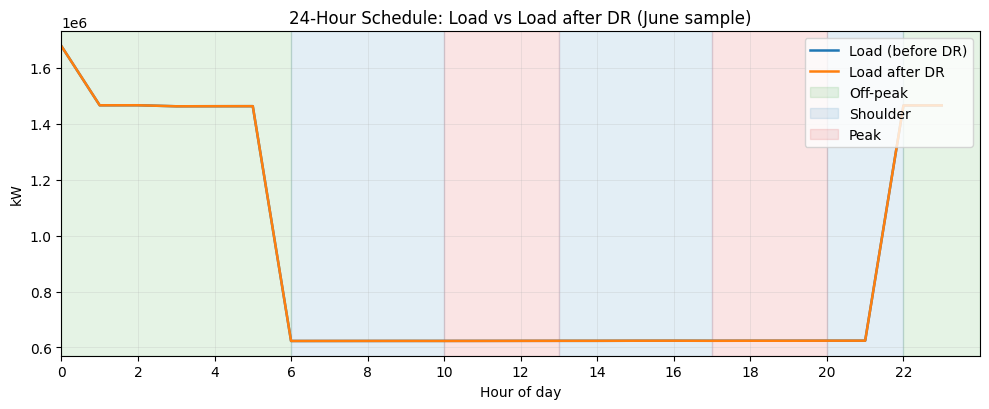

In [ ]:
# Example: use a representative DR week, averaged to 24h
by_hour, fig, ax = plot_24h_load_vs_dr(
    sol_plot,                       # your DataFrame with P_imp_kW, P_dis_kW, P_ch_kW, is_DR
    import_col="P_imp_kW",
    dis_col="P_dis_kW",
    ch_col="P_ch_kW",
    dr_col="is_DR",
    window=("2017-06-01", "2017-06-07"),  # or a single day: ("2017-06-03","2017-06-03")
    title="24-Hour Schedule: Load vs Load after DR (June sample)",
    outfile="24h_load_vs_dr.png"
)
print(by_hour.head())


shade_tou(ax)                 # add TOU bands
ax.set_xlim(0, 24)
ax.set_xticks(range(0, 24, 2))
fig.tight_layout()

In [ ]:
# by_hour, fig, ax = plot_24h_load_vs_dr(...)



In [ ]:
peak_drop = by_hour["Load_before_DR"].max() - by_hour["Load_after_DR"].max()
avg_drop  = (by_hour["Load_before_DR"] - by_hour["Load_after_DR"]).mean()
print(f"Peak reduction ≈ {peak_drop:.2f} kW; average hourly reduction ≈ {avg_drop:.2f} kW")


Peak reduction ≈ 0.00 kW; average hourly reduction ≈ 25.46 kW


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_monthly_bill_comparison(dv: pd.DataFrame, sol: pd.DataFrame, sector: str):
    """
    Compare monthly base vs optimized grid energy costs for a given sector.
    """
    # Ensure DateTime index
    if not isinstance(dv.index, pd.DatetimeIndex):
        dv.index = pd.to_datetime(dv.index)
    if not isinstance(sol.index, pd.DatetimeIndex):
        sol.index = pd.to_datetime(sol.index)

    # Compute monthly bills
    base_monthly = (dv["Import_Price"] * dv.get("P_imp_kW", 0.0) -
                    dv["Export_Price"] * dv.get("P_exp_kW", 0.0)).resample("M").sum()
    opt_monthly  = (sol["Import_Price"] * sol.get("P_imp_kW", 0.0) -
                    sol["Export_Price"] * sol.get("P_exp_kW", 0.0)).resample("M").sum()

    df_compare = pd.DataFrame({"Base_Bill": base_monthly, "Optimized_Bill": opt_monthly})
    df_compare["Savings"] = df_compare["Base_Bill"] - df_compare["Optimized_Bill"]

    # Plot
    plt.figure(figsize=(10,6))
    df_compare[["Base_Bill", "Optimized_Bill"]].plot(kind="bar", ax=plt.gca())
    plt.title(f"Monthly Electricity Bill Comparison ({sector.capitalize()} Sector, 2017)")
    plt.xlabel("Month")
    plt.ylabel("Monthly Cost ($)")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Print summary
    total_base = df_compare["Base_Bill"].sum()
    total_opt  = df_compare["Optimized_Bill"].sum()
    savings    = total_base - total_opt
    pct        = savings / total_base * 100 if total_base else 0
    print(f"\n💰 {sector.capitalize()} Total Annual Cost:")
    print(f"Base = ${total_base:,.2f}, Optimized = ${total_opt:,.2f}, Savings = ${savings:,.2f} ({pct:.2f}%)")

    return df_compare



=== RESIDENTIAL SECTOR (2017) ===


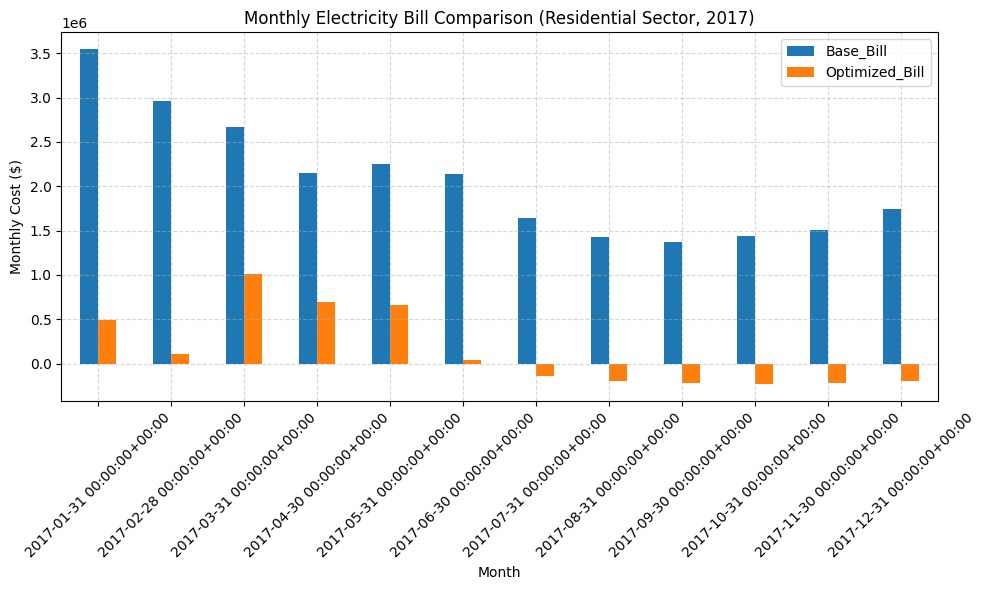


💰 Residential Total Annual Cost:
Base = $24,852,707.56, Optimized = $1,819,010.37, Savings = $23,033,697.19 (92.68%)

=== INDUSTRIAL SECTOR (2017) ===


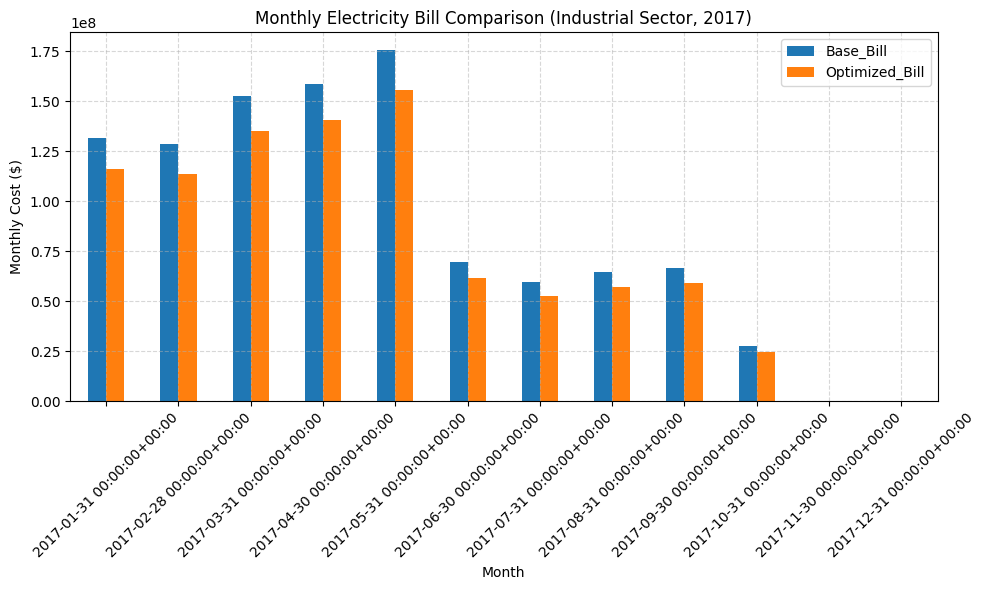


💰 Industrial Total Annual Cost:
Base = $1,035,312,133.90, Optimized = $916,418,013.06, Savings = $118,894,120.85 (11.48%)


In [ ]:
# Assume dvY and sol are already computed from your DSM model for each sector
sectors = ["residential", "industrial"]
bills_2017 = {}

for sec in sectors:
    print(f"\n=== {sec.upper()} SECTOR (2017) ===")
    dvY = prepare_sector_year(df_raw, sector=sec, year=2017)

    # Solve DSM optimization model
    m, sol, status, obj = build_dsm_model_DR(
        dvY, BATTERY[sec], PENALTIES,
        flex_cap=dict(peak=0.25, shoulder=1.5, offpeak=3.0),
        curt_limit=dict(peak=0.30, shoulder=0.15, offpeak=0.0),
        demand_charge_rate_per_kw_month=None,
        grid_cap_kW=None,
        sector=sec
    )

    # Save sector-specific solution
    bills_2017[sec] = plot_monthly_bill_comparison(dvY, sol, sec)


In [ ]:
import pandas as pd

def make_scenarios(dv_base: pd.DataFrame):
    """
    Return dict[str->DataFrame] and probabilities dict[str->float].
    Each scenario scales PV / Load / Price (you can replace with bootstrapped or forecasted series).
    """
    S = {}

    # High solar, low price
    s1 = dv_base.copy()
    s1["PV_kW"]         *= 2.0
    s1["Import_Price"]  *= 0.85
    s1["Export_Price"]  *= 0.85
    s1["Lcrit_kW"]      *= 0.98
    s1["Lflex_kW"]      *= 0.98
    s1["Lcurt_kW"]      *= 0.98
    S["hiPV_lowPrice"] = s1

    # Low solar, high price
    s2 = dv_base.copy()
    s2["PV_kW"]         *= 0.70
    s2["Import_Price"]  *= 1.20
    s2["Export_Price"]  *= 1.20
    s2["Lcrit_kW"]      *= 1.02
    s2["Lflex_kW"]      *= 1.02
    s2["Lcurt_kW"]      *= 1.02
    S["lowPV_hiPrice"] = s2

    # High demand (all loads up)
    s3 = dv_base.copy()
    for c in ["Lcrit_kW","Lflex_kW","Lcurt_kW"]:
        s3[c] *= 1.15
    S["hiDemand"] = s3

    # Nominal
    S["base"] = dv_base.copy()

    # Probabilities (sum to 1.0)
    p = {"hiPV_lowPrice":0.25, "lowPV_hiPrice":0.25, "hiDemand":0.25, "base":0.25}
    return S, p


In [ ]:
import pulp as pl

TOU_PEAK_HOURS     = {10,11,12,17,18,19}
TOU_SHOULDER_HOURS = {6,7,8,9,13,14,15,16,20,21}
TOU_OFFPEAK_HOURS  = {0,1,2,3,4,5,22,23}

def _tou_period(h):
    if h in TOU_OFFPEAK_HOURS:  return "offpeak"
    if h in TOU_SHOULDER_HOURS: return "shoulder"
    return "peak"

def build_dsm_model_stochastic(
    scenarios: dict[str, pd.DataFrame],
    probs: dict[str, float],
    battery: dict,
    penalties: dict,
    *,
    flex_cap = dict(peak=0.25, shoulder=1.5, offpeak=3.0),   # Sflex cap = α * Lflex
    curt_limit = dict(peak=0.30, shoulder=0.15, offpeak=0.0),# Ucurt cap = r * Lcurt
    demand_charge_rate_per_kw_month: float | None = None,
    horizon_weeks: float = 52.0,
    grid_cap_kW: float | None = None,
    sector: str = "residential"
):
    # Basic checks
    names = list(scenarios.keys())
    assert abs(sum(probs[n] for n in names) - 1.0) < 1e-6, "Probabilities must sum to 1."
    # All scenarios must share the same index
    idx = scenarios[names[0]].index
    for n in names: 
        assert scenarios[n].index.equals(idx), "All scenarios must have identical time index."
    T = range(len(idx))

    # Battery & penalties
    Emax     = float(battery["Emax_kWh"]);  E0 = float(battery["E0_kWh"])
    Pmax_ch  = float(battery["Pmax_ch_kW"]); Pmax_dis = float(battery["Pmax_dis_kW"])
    eta_ch   = float(battery["eta_ch"]);     eta_dis  = float(battery["eta_dis"])
    a_crit   = float(penalties.get("crit_unserved", 1000.0))
    a_curt   = float(penalties.get("curt_unserved", 100.0))
    if demand_charge_rate_per_kw_month is not None:
        weeks_per_month = 4.345
        a_peak = float(demand_charge_rate_per_kw_month) * (horizon_weeks / weeks_per_month)
    else:
        a_peak = 0.0

    # ---------------- Model ----------------
    m = pl.LpProblem(f"DSM_Stochastic_{sector}", pl.LpMinimize)

    # -------- Common (non-anticipative) decisions --------
    P_ch  = pl.LpVariable.dicts("P_ch",  T, lowBound=0, upBound=Pmax_ch)
    P_dis = pl.LpVariable.dicts("P_dis", T, lowBound=0, upBound=Pmax_dis)
    E     = pl.LpVariable.dicts("E",     T, lowBound=0, upBound=Emax)

    Sflex = pl.LpVariable.dicts("Sflex", T, lowBound=0)
    Scurt = pl.LpVariable.dicts("Scurt", T, lowBound=0)
    Ucrit = pl.LpVariable.dicts("Ucrit", T, lowBound=0)
    Ucurt = pl.LpVariable.dicts("Ucurt", T, lowBound=0)

    # Flexible energy conservation (Δt=1h) — use *expected* Lflex energy from any scenario (all share same Lflex shape here)
    base = scenarios[names[0]]
    total_Lflex = float(base["Lflex_kW"].sum())
    m += pl.lpSum(Sflex[t] for t in T) == total_Lflex, "flex_energy_quota"

    # TOU caps (use the base profile per hour for caps)
    for t in T:
        hour   = idx[t].hour
        period = _tou_period(hour)
        m += Sflex[t] <= float(flex_cap[period]) * base["Lflex_kW"].iloc[t], f"sflex_cap_{t}"
        m += Scurt[t] + Ucurt[t] == base["Lcurt_kW"].iloc[t],                 f"curt_balance_{t}"
        m += Ucurt[t] <= float(curt_limit[period]) * base["Lcurt_kW"].iloc[t], f"curt_limit_{t}"

    # SoC dynamics (common)
    for t in T:
        if t == 0:
            m += E[t] == E0 + eta_ch*P_ch[t] - (1/eta_dis)*P_dis[t], f"soc_{t}"
        else:
            m += E[t] == E[t-1] + eta_ch*P_ch[t] - (1/eta_dis)*P_dis[t], f"soc_{t}"
    m += E[len(idx)-1] == E0, "soc_cycle"

    # -------- Scenario-specific recourse --------
    P_imp = {n: pl.LpVariable.dicts(f"P_imp_{n}", T, lowBound=0) for n in names}
    P_exp = {n: pl.LpVariable.dicts(f"P_exp_{n}", T, lowBound=0) for n in names}
    PV_use  = {n: pl.LpVariable.dicts(f"PV_use_{n}",  T, lowBound=0) for n in names}
    PV_curt = {n: pl.LpVariable.dicts(f"PV_curt_{n}", T, lowBound=0) for n in names}
    Zpk     = {n: pl.LpVariable(f"PeakImport_{n}", lowBound=0)       for n in names}

    # Per-scenario constraints & expected-cost objective
    expected_energy_cost = 0
    expected_demand_cost = 0

    for n in names:
        dv = scenarios[n]
        c_buy  = dv["Import_Price"].to_dict()
        c_sell = dv["Export_Price"].to_dict()
        Lcrit  = dv["Lcrit_kW"].to_dict()
        PV     = dv["PV_kW"].to_dict()

        # PV split and power balance for each scenario
        for t in T:
            ts = idx[t]
            # PV split
            m += PV_use[n][t] + P_exp[n][t] + PV_curt[n][t] == PV[ts], f"pv_split_{n}_{t}"
            # Power balance
            m += PV_use[n][t] + P_dis[t] + P_imp[n][t] == (Lcrit[ts] - Ucrit[t]) + Sflex[t] + Scurt[t] + P_ch[t] + P_exp[n][t], f"bal_{n}_{t}"
            # Peak tracker and optional grid cap
            m += P_imp[n][t] <= Zpk[n], f"peak_{n}_{t}"
            if grid_cap_kW is not None:
                m += P_imp[n][t] <= float(grid_cap_kW), f"gridcap_{n}_{t}"

        # Add scenario contribution to expected cost
        scen_energy_cost = pl.lpSum(c_buy[idx[t]]*P_imp[n][t] - c_sell[idx[t]]*P_exp[n][t] for t in T)
        scen_reliab_cost = a_crit*pl.lpSum(Ucrit[t] for t in T) + a_curt*pl.lpSum(Ucurt[t] for t in T)
        expected_energy_cost += probs[n] * (scen_energy_cost + scen_reliab_cost)
        expected_demand_cost += probs[n] * (a_peak * Zpk[n])

    # Final objective: expected energy + expected demand
    m += expected_energy_cost + expected_demand_cost, "Expected_Total_Cost"

    # Solve
    m.solve(pl.PULP_CBC_CMD(msg=False))

    # Collect solution (common + scenario views)
    sol_common = pd.DataFrame(index=idx)
    sol_common["P_ch_kW"]  = [pl.value(P_ch[t])  for t in T]
    sol_common["P_dis_kW"] = [pl.value(P_dis[t]) for t in T]
    sol_common["SoC_kWh"]  = [pl.value(E[t])     for t in T]
    sol_common["Sflex_kW"] = [pl.value(Sflex[t]) for t in T]
    sol_common["Scurt_kW"] = [pl.value(Scurt[t]) for t in T]
    sol_common["Ucrit_kW"] = [pl.value(Ucrit[t]) for t in T]
    sol_common["Ucurt_kW"] = [pl.value(Ucurt[t]) for t in T]

    sol_scen = {}
    for n in names:
        df = pd.DataFrame(index=idx)
        df["P_imp_kW"] = [pl.value(P_imp[n][t]) for t in T]
        df["P_exp_kW"] = [pl.value(P_exp[n][t]) for t in T]
        df["PV_use"]   = [pl.value(PV_use[n][t]) for t in T]
        df["PV_curt"]  = [pl.value(PV_curt[n][t]) for t in T]
        df["PeakImport_kW"] = float(pl.value(Zpk[n]))
        # pass-through (scenario inputs for reporting)
        for c in ["PV_kW","Import_Price","Export_Price","Lcrit_kW","Lflex_kW","Lcurt_kW"]:
            df[c] = scenarios[n][c].values
        df["Energy_Cost"] = df["P_imp_kW"]*df["Import_Price"] - df["P_exp_kW"]*df["Export_Price"]
        sol_scen[n] = df

    status = pl.LpStatus[m.status]
    obj    = float(pl.value(m.objective))
    return m, sol_common, sol_scen, status, obj


In [ ]:
BATTERY = {
    "residential": {
        "Emax_kWh":     13.5,   # usable capacity (e.g., Powerwall-class)
        "E0_kWh":        6.8,   # start SoC ~50% for cyclic horizon
        "Pmax_ch_kW":    5.0,   # inverter/charger limit
        "Pmax_dis_kW":   5.0,   # inverter discharge limit
        "eta_ch":        0.96,  # charge efficiency
        "eta_dis":       0.96   # discharge efficiency
    },
    "industrial": {
        "Emax_kWh":    400.0,
        "E0_kWh":      200.0,
        "Pmax_ch_kW":  200.0,
        "Pmax_dis_kW": 200.0,
        "eta_ch":        0.95,
        "eta_dis":       0.95
    }
}

PENALTIES = {"crit_unserved": 1000.0, "curt_unserved": 100.0}


In [ ]:
# 1) Build your deterministic annual DV first (e.g., 2017)
dv_residential = prepare_sector_year(df_raw, sector="residential", year=2017)   # your existing helper

# 2) Create scenarios & probabilities
scens, probs = make_scenarios(dv_residential)

m, sol_common, sol_scen, status, obj = build_dsm_model_stochastic(
    scenarios=scenarios,      # dictionary of scenario dataframes
    probs=probs,              # dictionary of probabilities
    battery=BATTERY["residential"],
    penalties=PENALTIES,
    flex_cap   = dict(peak=0.25, shoulder=1.5, offpeak=3.0),
    curt_limit = dict(peak=0.30, shoulder=0.15, offpeak=0.0),
    demand_charge_rate_per_kw_month=None,
    grid_cap_kW=None,
    sector="residential"
)

for name, df in sol_scen.items():
    print(name, "Total bill:", df["Energy_Cost"].sum(), "Peak kW:", df["PeakImport_kW"].iloc[0])


hiPV_lowPrice Total bill: 728603497.2950499 Peak kW: 2025710.9
lowPV_hiPrice Total bill: 1117036097.96592 Peak kW: 2107358.4
hiDemand Total bill: 988727265.9832001 Peak kW: 2182191.9
base Total bill: 908068822.3366002 Peak kW: 2081271.1


In [ ]:
import pandas as pd
rows = []
for name, df in sol_scen.items():
    rows.append({
        "Scenario": name,
        "Total Bill ($)": df["Energy_Cost"].sum(),
        "Peak Import (kW)": df["PeakImport_kW"].iloc[0],
        "PV Used (kWh)": df["PV_use"].sum(),
        "PV Export (kWh)": df["P_exp_kW"].sum(),
        "PV Curtailment (kWh)": df["PV_curt"].sum()
    })
pd.DataFrame(rows)


,Scenario,Total Bill ($),Peak Import (kW),PV Used (kWh),PV Export (kWh),PV Curtailment (kWh)
0,hiPV_lowPrice,7.286035e+08,2025710.9,4.224585e+08,0.0,0.0
1,lowPV_hiPrice,1.117036e+09,2107358.4,1.478605e+08,0.0,0.0
2,hiDemand,9.887273e+08,2182191.9,2.112292e+08,0.0,0.0
3,base,9.080688e+08,2081271.1,2.112292e+08,0.0,0.0


In [ ]:
import pandas as pd

def run_stochastic_dsm_for_sector(sector: str, df_raw: pd.DataFrame):
    """
    Runs the stochastic DSM model for a given sector and year (2017),
    and returns a summary DataFrame of scenario-level results.
    """
    # 1) Deterministic baseline
    dv = prepare_sector_year(df_raw, sector=sector, year=2017)

    # 2) Create stochastic scenarios and probabilities
    scens, probs = make_scenarios(dv)

    # 3) Solve stochastic DSM model
    m, sol_common, sol_scen, status, obj = build_dsm_model_stochastic(
        scenarios=scens,
        probs=probs,
        battery=BATTERY[sector],
        penalties=PENALTIES,
        flex_cap=dict(peak=0.25, shoulder=1.5, offpeak=3.0),
        curt_limit=dict(peak=0.30, shoulder=0.15, offpeak=0.0),
        demand_charge_rate_per_kw_month=None,
        grid_cap_kW=None,
        sector=sector
    )

    # 4) Extract scenario results
    rows = []
    for name, df in sol_scen.items():
        rows.append({
            "Sector": sector.capitalize(),
            "Scenario": name,
            "Total Bill ($)": round(df["Energy_Cost"].sum(), 2),
            "Peak Import (kW)": round(df["PeakImport_kW"].iloc[0], 2),
            "PV Used (kWh)": round(df["PV_use"].sum(), 2),
            "PV Export (kWh)": round(df["P_exp_kW"].sum(), 2),
            "PV Curtailment (kWh)": round(df["PV_curt"].sum(), 2)
        })

    summary = pd.DataFrame(rows)
    summary["Status"] = status
    summary["Objective Value"] = round(obj, 2)
    return summary, sol_common, sol_scen


# ===============================
# Run for both sectors at once
# ===============================
all_results = []
sector_solutions = {}

for sec in ["residential", "industrial"]:
    print(f"\n🔹 Running Stochastic DSM for {sec.upper()} (2017)")
    summary_df, sol_common, sol_scen = run_stochastic_dsm_for_sector(sec, df_raw)
    all_results.append(summary_df)
    sector_solutions[sec] = {"common": sol_common, "scenarios": sol_scen}

# Combine all results into one master table
final_summary = pd.concat(all_results, ignore_index=True)

# Order columns for report clarity
final_summary = final_summary[
    ["Sector", "Scenario", "Total Bill ($)", "Peak Import (kW)",
     "PV Used (kWh)", "PV Export (kWh)", "PV Curtailment (kWh)",
     "Status", "Objective Value"]
]

# Display neatly
display(final_summary.style.set_caption("Stochastic DSM Optimization Results (2017)")
        .format({"Total Bill ($)": "{:,.2f}", "Peak Import (kW)": "{:,.2f}"}))

# Optionally export for report
final_summary.to_csv("data/Stochastic_DSM_Summary_2017.csv", index=False)
print("✅ Exported: data/Stochastic_DSM_Summary_2017.csv")



🔹 Running Stochastic DSM for RESIDENTIAL (2017)

🔹 Running Stochastic DSM for INDUSTRIAL (2017)


,Sector,Scenario,Total Bill ($),Peak Import (kW),PV Used (kWh),PV Export (kWh),PV Curtailment (kWh),Status,Objective Value
0,Residential,hiPV_lowPrice,"-9,582,174.39",0.00,555635361.340000,187885772.390000,0.000000,Optimal,4890306.090000
1,Residential,lowPV_hiPrice,"20,850,284.41","59,172.40",259210649.780000,1021747.010000,0.000000,Optimal,4890306.090000
2,Residential,hiDemand,"5,161,203.05","49,629.98",362695222.910000,9065343.950000,0.000000,Optimal,4890306.090000
3,Residential,base,"3,131,911.30","45,199.12",354188766.750000,17571800.110000,0.000000,Optimal,4890306.090000
4,Industrial,hiPV_lowPrice,"728,579,726.00","2,025,710.90",422458477.110000,0.000000,0.000000,Optimal,935580605.140000
5,Industrial,lowPV_hiPrice,"1,117,002,538.60","2,107,358.40",147860466.620000,0.000000,0.000000,Optimal,935580605.140000
6,Industrial,hiDemand,"988,699,299.82","2,182,191.90",211229238.100000,0.000000,0.000000,Optimal,935580605.140000
7,Industrial,base,"908,040,856.15","2,081,271.10",211229238.100000,0.000000,0.000000,Optimal,935580605.140000


✅ Exported: data/Stochastic_DSM_Summary_2017.csv


In [ ]:

import pandas as pd
from IPython.display import display

# -------------------------
# 1. Common (non-anticipative) decisions
# -------------------------
common_summary = sol_common.describe().T
common_summary.index.name = "Variable"
common_summary = common_summary[["mean", "min", "max"]]
common_summary.columns = ["Mean (kW)", "Min (kW)", "Max (kW)"]

print("=== Common DSM Decisions (Battery & Load Variables) ===")
display(common_summary)

# -------------------------
# 2. Scenario-wise results
# -------------------------
scenario_results = []
for name, df in sol_scen.items():
    total_bill = df["Energy_Cost"].sum()
    total_import = df["P_imp_kW"].sum()
    total_export = df["P_exp_kW"].sum()
    total_pv_use = df["PV_use"].sum()
    total_pv_curt = df["PV_curt"].sum()
    peak_kw = df["PeakImport_kW"].iloc[0]
    scenario_results.append({
        "Scenario": name,
        "Probability": probs[name],
        "Total Bill ($)": round(total_bill, 2),
        "Peak Import (kW)": round(peak_kw, 2),
        "Total Import (kWh)": round(total_import, 2),
        "Total Export (kWh)": round(total_export, 2),
        "PV Used (kWh)": round(total_pv_use, 2),
        "PV Curtailed (kWh)": round(total_pv_curt, 2)
    })

scenario_df = pd.DataFrame(scenario_results).set_index("Scenario")

print("\n=== Scenario Comparison Table ===")
display(scenario_df)

# -------------------------
# 3. Expected weighted bill
# -------------------------
expected_bill = sum(probs[n] * sol_scen[n]["Energy_Cost"].sum() for n in sol_scen)
expected_peak = sum(probs[n] * sol_scen[n]["PeakImport_kW"].iloc[0] for n in sol_scen)

expected_summary = pd.DataFrame({
    "Metric": ["Expected Total Energy Cost ($)", "Expected Peak Demand (kW)", "Objective Value"],
    "Value": [round(expected_bill, 2), round(expected_peak, 2), round(obj, 2)]
}).set_index("Metric")

print("\n=== Expected Stochastic Summary ===")
display(expected_summary)

# -------------------------
# 4. Optional: Export for Report
# -------------------------
common_summary.to_csv("outputs/stochastic_common_summary.csv")
scenario_df.to_csv("outputs/stochastic_scenario_comparison.csv")
expected_summary.to_csv("outputs/stochastic_expected_summary.csv")



=== Common DSM Decisions (Battery & Load Variables) ===


,Mean (kW),Min (kW),Max (kW)
Variable,,,
P_ch_kW,27.397260,0.000000e+00,200.00
P_dis_kW,24.726027,-9.500000e-13,200.00
SoC_kWh,105.489726,0.000000e+00,400.00
Sflex_kW,189966.951850,0.000000e+00,1186829.50
Scurt_kW,126644.634571,0.000000e+00,263739.88
Ucrit_kW,0.000000,0.000000e+00,0.00
Ucurt_kW,0.000000,0.000000e+00,0.00



=== Scenario Comparison Table ===


,Probability,Total Bill ($),Peak Import (kW),Total Import (kWh),Total Export (kWh),PV Used (kWh),PV Curtailed (kWh)
Scenario,,,,,,,
hiPV_lowPrice,0.25,7.285797e+08,2025710.9,5.124600e+09,0.0,4.224585e+08,0.0
lowPV_hiPrice,0.25,1.117003e+09,2107358.4,5.512403e+09,0.0,1.478605e+08,0.0
hiDemand,0.25,9.886993e+08,2182191.9,5.816950e+09,0.0,2.112292e+08,0.0
base,0.25,9.080409e+08,2081271.1,5.392432e+09,0.0,2.112292e+08,0.0



=== Expected Stochastic Summary ===


,Value
Metric,
Expected Total Energy Cost ($),9.355806e+08
Expected Peak Demand (kW),2.099133e+06
Objective Value,9.164180e+08


In [ ]:
import matplotlib.pyplot as plt

def plot_fig2_before_after(dv: pd.DataFrame, sol: pd.DataFrame, critical_idx):
    """Fig. 2 — baseline vs optimized import on DR hours (bar plot)."""
    # Baseline import (fallback if dv lacks P_imp_kW)
    if "P_imp_kW" in dv.columns:
        base_imp = dv["P_imp_kW"].reindex(sol.index).fillna(0.0)
    else:
        # simple baseline reconstruction: load - PV (no battery)
        L = (dv["Lcrit_kW"] + dv["Lflex_kW"] + dv["Lcurt_kW"]).reindex(sol.index).fillna(0.0)
        base_imp = (L - dv["PV_kW"].reindex(sol.index).fillna(0.0)).clip(lower=0.0)

    fig, ax = plt.subplots(figsize=(10,4))
    x = range(len(critical_idx))
    ax.bar([i-0.2 for i in x], base_imp.loc[critical_idx].values, width=0.4, label="Baseline")
    ax.bar([i+0.2 for i in x], sol.loc[critical_idx, "P_imp_kW"].values, width=0.4, label="Optimized")
    ax.set_xticks(x); ax.set_xticklabels([ts.strftime("%m-%d %H:%M") for ts in critical_idx], rotation=45, ha="right")
    ax.set_title("Fig. 2 — Import reduction on DR hours (before vs after)")
    ax.set_ylabel("kW"); ax.grid(True, axis="y", alpha=.3); ax.legend()
    plt.tight_layout(); plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# Helpers: choose the “DR week”
# ----------------------------
def pick_top_dr_week(dr_flags: pd.DataFrame) -> pd.Timestamp:
    """Return the Monday (00:00) of the week with most DR hours."""
    f = dr_flags.copy()
    f["DR"] = f["is_peak_price"] | f["is_peak_import"]
    weekly = f["DR"].resample("W-MON").sum(min_count=1).fillna(0).sort_values(ascending=False)
    if weekly.empty or weekly.iloc[0] == 0:
        # fallback: first full week in data
        start = dr_flags.index.min().normalize()
        return (start + pd.offsets.Week(weekday=0))
    return weekly.index[0]  # this is the Monday label

def slice_week(df: pd.DataFrame, week_start: pd.Timestamp) -> pd.DataFrame:
    # Handle both tz-aware and tz-naive time indices properly
    if hasattr(df.index, "tz") and df.index.tz is not None:
        start = pd.Timestamp(week_start).tz_convert(df.index.tz)
    else:
        start = pd.Timestamp(week_start)
    end = start + pd.Timedelta(days=7) - pd.Timedelta(seconds=1)
    return df.loc[start:end]

# ----------------------------
# Core: make plots for a DR week
# ----------------------------
def plot_dr_week(dv_baseline: pd.DataFrame,
                 sol_opt: pd.DataFrame,
                 dr_flags: pd.DataFrame,
                 week_start: pd.Timestamp | None = None,
                 outdir: str = "outputs/dr_week",
                 title_prefix: str = "DR Week"):
    Path(outdir).mkdir(parents=True, exist_ok=True)

    # Pick week automatically if not given
    if week_start is None:
        week_start = pick_top_dr_week(dr_flags)
    wk_flags = slice_week(dr_flags, week_start)
    wk_base  = slice_week(dv_baseline, week_start)
    wk_opt   = slice_week(sol_opt, week_start)

    # Ensure needed columns exist (fill zeros if missing)
    for df in (wk_base, wk_opt):
        for c in ["P_imp_kW","P_exp_kW","PV_kW","P_ch_kW","P_dis_kW","SoC_kWh","Import_Price"]:
            if c not in df.columns:
                df[c] = 0.0

    # DR mask (for shading)
    dr_mask = (wk_flags["is_peak_price"] | wk_flags["is_peak_import"]).astype(bool)

    # ------------- Figure A: Grid import (before vs after) -------------
    figA, axA = plt.subplots(figsize=(12,4))
    axA.plot(wk_base.index, wk_base["P_imp_kW"], label="Import (Baseline)", linewidth=1.5)
    axA.plot(wk_opt.index,  wk_opt["P_imp_kW"],  label="Import (Optimized)", linewidth=1.5)
    # Shade DR hours
    for ts, is_dr in dr_mask.items():
        if is_dr:
            axA.axvspan(ts, ts + pd.Timedelta(hours=1), alpha=0.12)
    axA.set_title(f"{title_prefix}: Grid Import (kW)")
    axA.set_ylabel("kW"); axA.grid(True, alpha=0.3); axA.legend()
    figA.tight_layout()
    pA = f"{outdir}/A_grid_import_before_after.png"
    figA.savefig(pA, dpi=160); plt.close(figA)

    # ------------- Figure B: PV and Battery utilization -------------
    figB, axB = plt.subplots(figsize=(12,4))
    axB.plot(wk_opt.index, wk_opt["PV_kW"],     label="PV (kW)", linewidth=1.2)
    axB.plot(wk_opt.index, wk_opt["P_ch_kW"],   label="Battery Charge (kW)", linewidth=1.2)
    axB.plot(wk_opt.index, wk_opt["P_dis_kW"],  label="Battery Discharge (kW)", linewidth=1.2)
    # Shade DR hours
    for ts, is_dr in dr_mask.items():
        if is_dr:
            axB.axvspan(ts, ts + pd.Timedelta(hours=1), alpha=0.12)
    axB.set_title(f"{title_prefix}: PV & Battery Utilization")
    axB.set_ylabel("kW"); axB.grid(True, alpha=0.3); axB.legend(ncol=3)
    figB.tight_layout()
    pB = f"{outdir}/B_pv_bess_utilization.png"
    figB.savefig(pB, dpi=160); plt.close(figB)

    # ------------- Figure C: Battery SoC -------------
    figC, axC = plt.subplots(figsize=(12,3.8))
    axC.plot(wk_opt.index, wk_opt["SoC_kWh"], label="Battery SoC (kWh)", linewidth=1.5)
    for ts, is_dr in dr_mask.items():
        if is_dr:
            axC.axvspan(ts, ts + pd.Timedelta(hours=1), alpha=0.12)
    axC.set_title(f"{title_prefix}: Battery State of Charge")
    axC.set_ylabel("kWh"); axC.grid(True, alpha=0.3); axC.legend()
    figC.tight_layout()
    pC = f"{outdir}/C_battery_soc.png"
    figC.savefig(pC, dpi=160); plt.close(figC)

    # ------------- DR schedule table for the week -------------
    # Reuse your functions
    flags_week = wk_flags[["Import_Price","is_peak_price","is_peak_import"]]
    dr_sched   = wk_opt[["P_imp_kW","P_ch_kW","P_dis_kW","SoC_kWh"]].copy()
    dr_sched   = dr_sched.merge(flags_week, left_index=True, right_index=True, how="left")
    dr_sched["Batt_Action_kW"] = dr_sched["P_dis_kW"] - dr_sched["P_ch_kW"]
    dr_sched = dr_sched[(dr_sched["is_peak_price"]) | (dr_sched["is_peak_import"])].copy()

    csv_path = f"{outdir}/DR_schedule_week.csv"
    dr_sched.to_csv(csv_path, index=True)

    # ------------- Quick textual summary -------------
    summary = {
        "week_start": str(week_start),
        "dr_hours": int(dr_mask.sum()),
        "import_reduction_kWh": float((wk_base["P_imp_kW"] - wk_opt["P_imp_kW"]).clip(lower=0).sum()),
        "avg_peak_price_$perkWh": float(wk_flags.loc[dr_mask, "Import_Price"].mean()) if "Import_Price" in wk_flags else np.nan
    }

    print("Saved:")
    print(" ", pA)
    print(" ", pB)
    print(" ", pC)
    print(" ", csv_path)
    print("Summary:", summary)

    return {"fig_grid": pA, "fig_pv_bess": pB, "fig_soc": pC, "dr_csv": csv_path, "summary": summary}

# ----------------------------
# Usage example (after you solved for a sector)
# ----------------------------
# 1) Identify DR events from optimized solution
flags = identify_dr_events(sol, price_thresh=None, topN_peak_hours=20)

# 2) Plot the week with the most DR activity
assets = plot_dr_week(dvY, sol, flags, week_start=None, outdir="outputs/dr_week_res", title_prefix="Residential DR Week")


Saved:
  outputs/dr_week_res/A_grid_import_before_after.png
  outputs/dr_week_res/B_pv_bess_utilization.png
  outputs/dr_week_res/C_battery_soc.png
  outputs/dr_week_res/DR_schedule_week.csv
Summary: {'week_start': '2017-06-05 00:00:00+00:00', 'dr_hours': 43, 'import_reduction_kWh': 13133650.889000002, 'avg_peak_price_$perkWh': 0.29581395348837214}


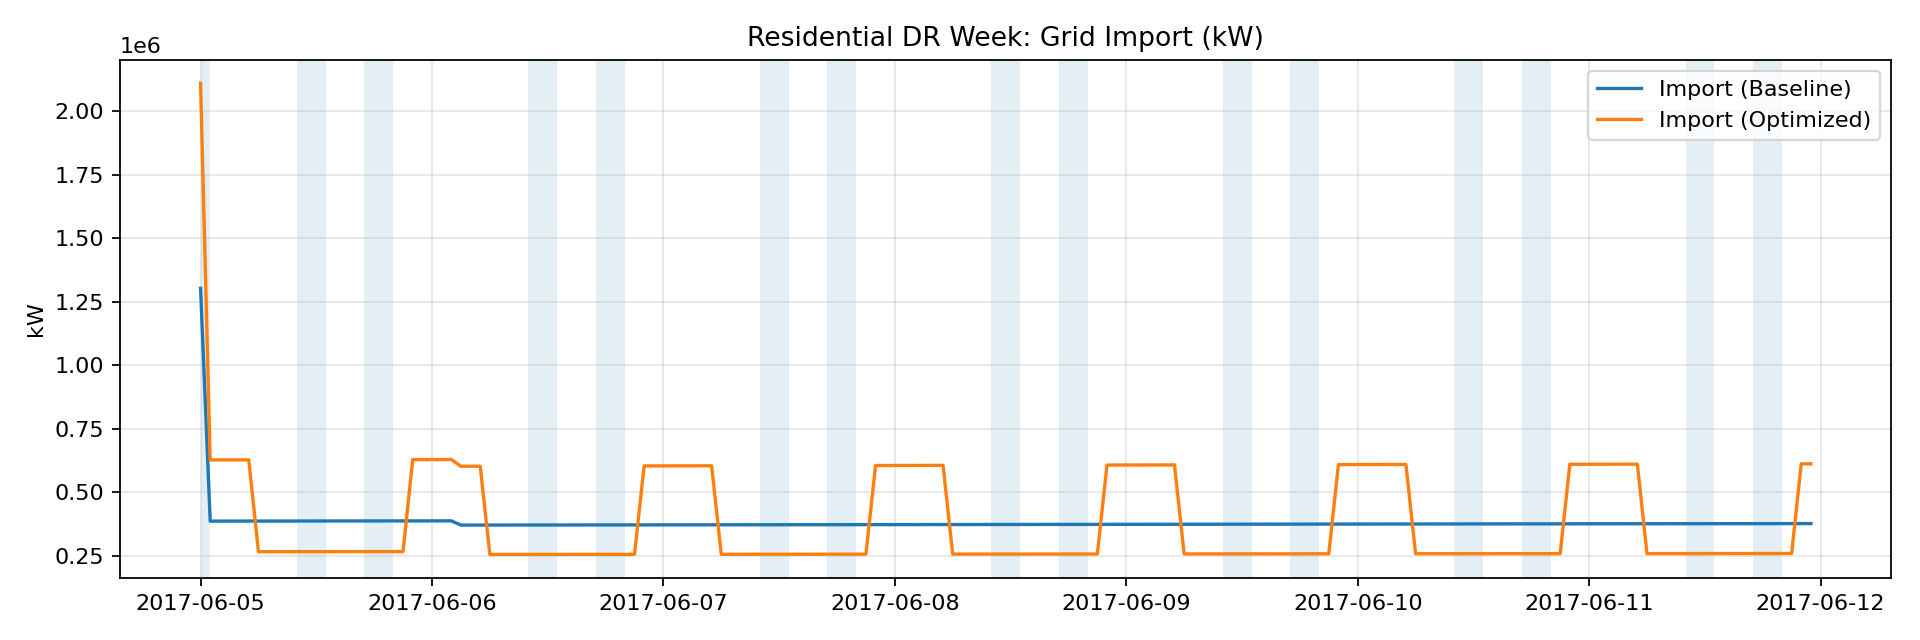

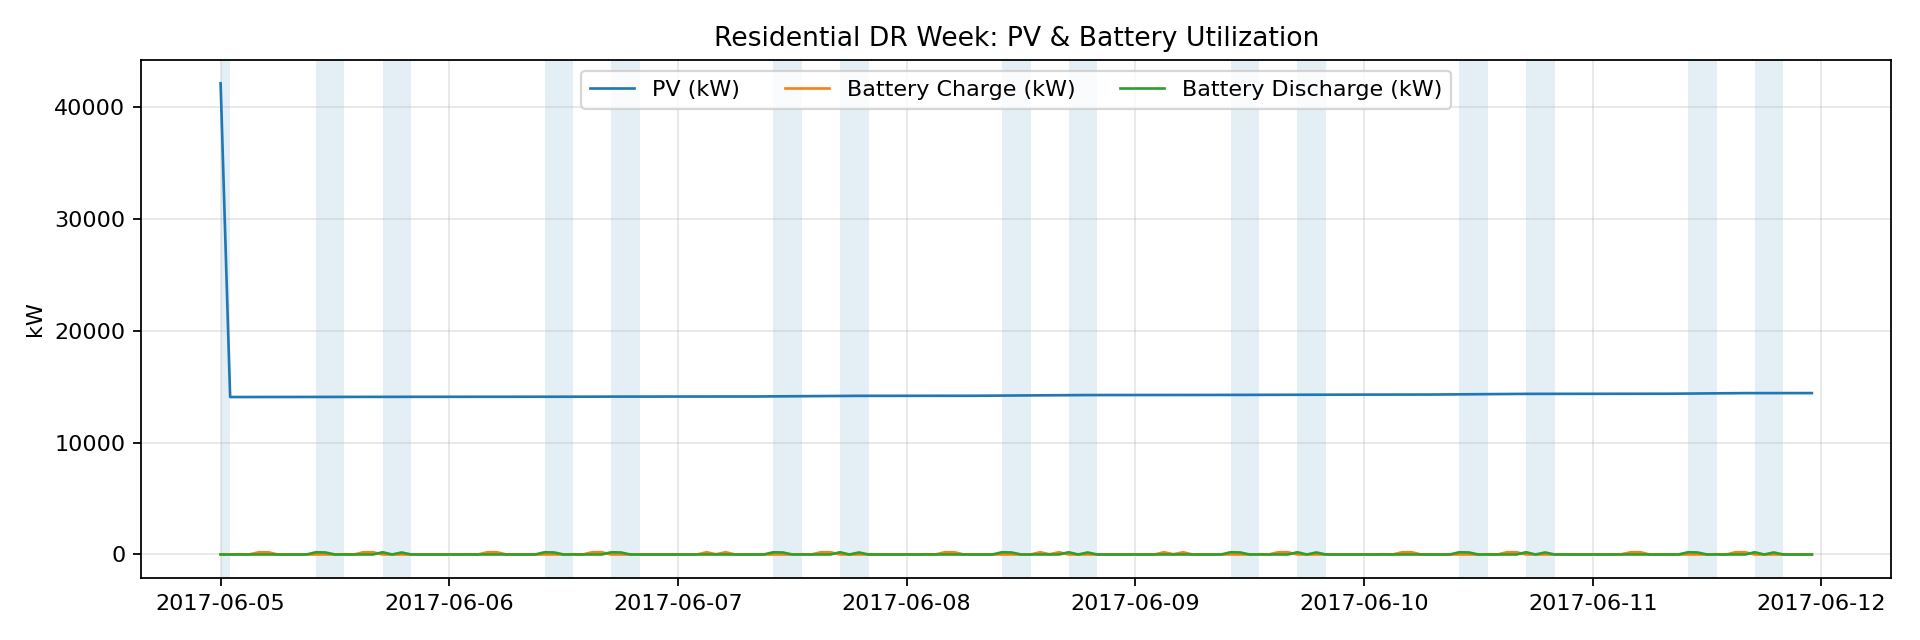

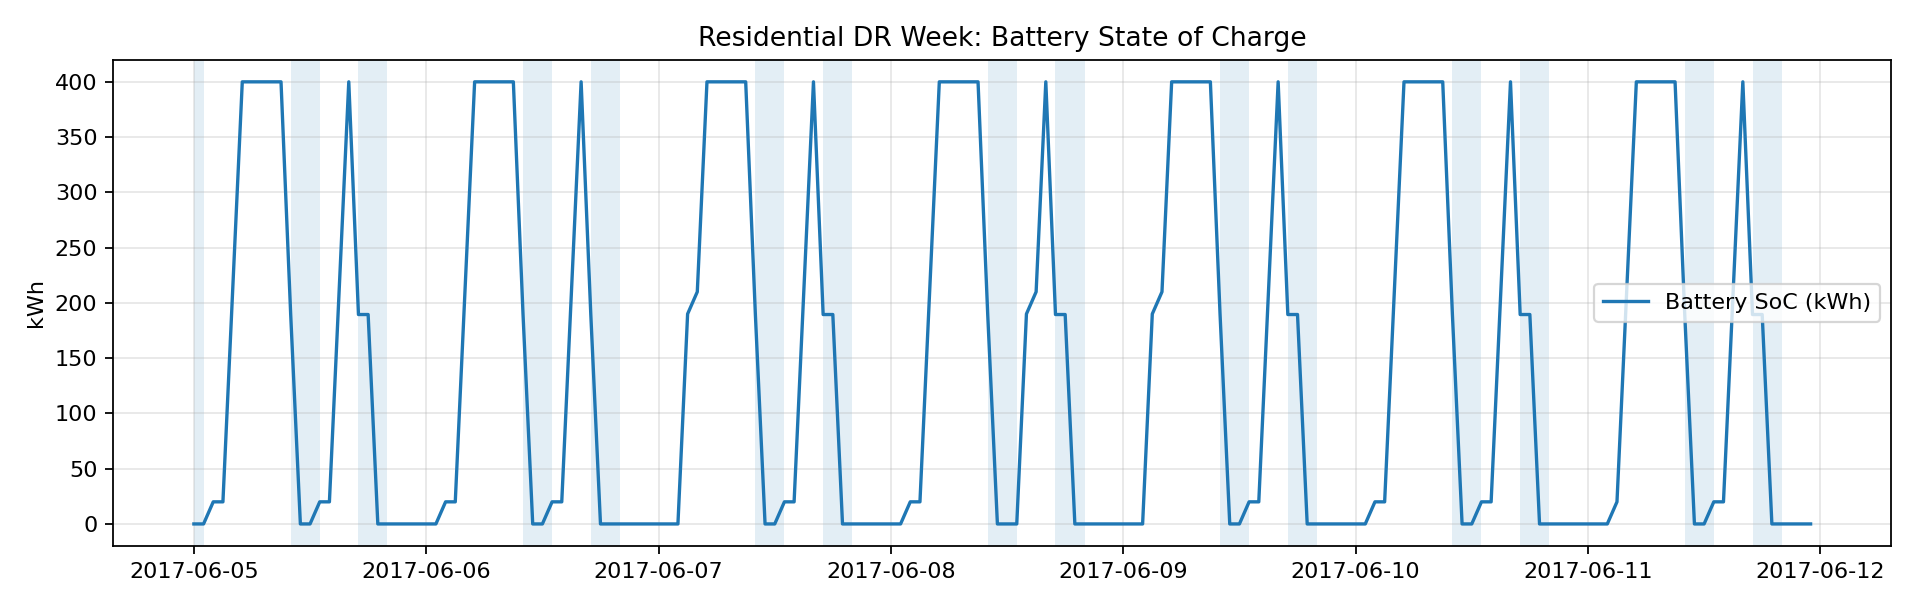

In [ ]:
from IPython.display import Image, display
display(Image(filename=assets["fig_grid"]))
display(Image(filename=assets["fig_pv_bess"]))
display(Image(filename=assets["fig_soc"]))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_dr_week_compare(
    dv_res, sol_res, flags_res,
    dv_ind, sol_ind, flags_ind,
    week_res=None, week_ind=None,
    outdir="outputs/dr_week_compare",
    title_prefix="DR Week Comparison"
):
    Path(outdir).mkdir(parents=True, exist_ok=True)

    # Helper: slice week data
    def slice_week(df, week_start):
        if hasattr(df.index, "tz") and df.index.tz is not None:
            start = pd.Timestamp(week_start).tz_convert(df.index.tz)
        else:
            start = pd.Timestamp(week_start)
        end = start + pd.Timedelta(days=7) - pd.Timedelta(seconds=1)
        return df.loc[start:end]

    # If week not provided, pick automatically
    def pick_top_week(dr_flags):
        f = dr_flags.copy()
        f["DR"] = f["is_peak_price"] | f["is_peak_import"]
        weekly = f["DR"].resample("W-MON").sum(min_count=1).fillna(0)
        if weekly.empty or weekly.max() == 0:
            return dr_flags.index.min().normalize() + pd.offsets.Week(weekday=0)
        return weekly.sort_values(ascending=False).index[0]

    week_res = week_res or pick_top_week(flags_res)
    week_ind = week_ind or pick_top_week(flags_ind)

    # Slice each dataset for its DR week
    res_base, res_opt, res_flags = map(lambda df: slice_week(df, week_res), [dv_res, sol_res, flags_res])
    ind_base, ind_opt, ind_flags = map(lambda df: slice_week(df, week_ind), [dv_ind, sol_ind, flags_ind])

    # Ensure needed columns
    for df in (res_base, res_opt, ind_base, ind_opt):
        for c in ["P_imp_kW","PV_kW","P_ch_kW","P_dis_kW","SoC_kWh"]:
            if c not in df.columns: df[c] = 0.0

    # DR masks
    dr_mask_res = (res_flags["is_peak_price"] | res_flags["is_peak_import"]).astype(bool)
    dr_mask_ind = (ind_flags["is_peak_price"] | ind_flags["is_peak_import"]).astype(bool)

    # =======================
    # A. Grid Import (kW)
    # =======================
    figA, axA = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    # Residential
    axA[0].plot(res_base.index, res_base["P_imp_kW"], label="Baseline", lw=1.3)
    axA[0].plot(res_opt.index,  res_opt["P_imp_kW"],  label="Optimized", lw=1.3)
    for ts, is_dr in dr_mask_res.items():
        if is_dr:
            axA[0].axvspan(ts, ts+pd.Timedelta(hours=1), color="orange", alpha=0.15)
    axA[0].set_title("Residential – Grid Import (kW)")
    axA[0].set_ylabel("kW"); axA[0].grid(alpha=0.3); axA[0].legend()

    # Industrial
    axA[1].plot(ind_base.index, ind_base["P_imp_kW"], label="Baseline", lw=1.3)
    axA[1].plot(ind_opt.index,  ind_opt["P_imp_kW"],  label="Optimized", lw=1.3)
    for ts, is_dr in dr_mask_ind.items():
        if is_dr:
            axA[1].axvspan(ts, ts+pd.Timedelta(hours=1), color="orange", alpha=0.15)
    axA[1].set_title("Industrial – Grid Import (kW)")
    axA[1].grid(alpha=0.3); axA[1].legend()
    figA.suptitle(f"{title_prefix}: Grid Import Response")
    figA.tight_layout()
    figA.savefig(f"{outdir}/A_grid_import_comparison.png", dpi=160)
    plt.close(figA)

    # =======================
    # B. PV & Battery Utilization
    # =======================
    figB, axB = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    for (ax, opt, dr_mask, name) in [
        (axB[0], res_opt, dr_mask_res, "Residential"),
        (axB[1], ind_opt, dr_mask_ind, "Industrial")
    ]:
        ax.plot(opt.index, opt["PV_kW"], label="PV", lw=1.1)
        ax.plot(opt.index, opt["P_ch_kW"], label="Battery Charge", lw=1.1)
        ax.plot(opt.index, opt["P_dis_kW"], label="Battery Discharge", lw=1.1)
        for ts, is_dr in dr_mask.items():
            if is_dr:
                ax.axvspan(ts, ts+pd.Timedelta(hours=1), color="orange", alpha=0.12)
        ax.set_title(f"{name} – PV & BESS Utilization")
        ax.set_ylabel("kW"); ax.grid(alpha=0.3)
    axB[0].legend(ncol=3)
    figB.suptitle(f"{title_prefix}: PV & Battery Operation")
    figB.tight_layout()
    figB.savefig(f"{outdir}/B_pv_bess_comparison.png", dpi=160)
    plt.close(figB)

    # =======================
    # C. Battery SoC
    # =======================
    figC, axC = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    for (ax, opt, dr_mask, name) in [
        (axC[0], res_opt, dr_mask_res, "Residential"),
        (axC[1], ind_opt, dr_mask_ind, "Industrial")
    ]:
        ax.plot(opt.index, opt["SoC_kWh"], label="Battery SoC", lw=1.5)
        for ts, is_dr in dr_mask.items():
            if is_dr:
                ax.axvspan(ts, ts+pd.Timedelta(hours=1), color="orange", alpha=0.12)
        ax.set_title(f"{name} – Battery State of Charge")
        ax.set_ylabel("kWh"); ax.grid(alpha=0.3)
    axC[0].legend()
    figC.suptitle(f"{title_prefix}: Battery SoC Comparison")
    figC.tight_layout()
    figC.savefig(f"{outdir}/C_battery_soc_comparison.png", dpi=160)
    plt.close(figC)

    print("✅ Saved comparative DR week plots to:", Path(outdir).resolve())



In [ ]:
# --- Solve both sectors (assuming 2017) ---
dv_res = prepare_sector_year(df_raw, "residential", 2017)
m_res, sol_res, _, _ = build_dsm_model_DR(dv_res, BATTERY["residential"], PENALTIES, sector="residential")
flags_res = identify_dr_events(sol_res)

dv_ind = prepare_sector_year(df_raw, "industrial", 2017)
m_ind, sol_ind, _, _ = build_dsm_model_DR(dv_ind, BATTERY["industrial"], PENALTIES, sector="industrial")
flags_ind = identify_dr_events(sol_ind)

# --- Create combined plots ---
plot_dr_week_compare(
    dv_res, sol_res, flags_res,
    dv_ind, sol_ind, flags_ind,
    outdir="outputs/dr_week_compare",
    title_prefix="Residential vs Industrial DR Weeks"
)


✅ Saved comparative DR week plots to: /Users/ruheeshrestha/Desktop/oie-559-project/outputs/dr_week_compare
